In [1]:
import ee
import urllib.request
import pandas as pd
import numpy as np

ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AbUR2VOe_E8tF3XTho19C0Uhy_jKxEfrIHLgylZ-IFjhfgK8eY7FULoy-2c

Successfully saved authorization token.


# Data downloads

## Satellite images

### Attempt 1: gee tools

In [ ]:
import geetools

In [ ]:
# Define an ImageCollection
site = ee.Geometry.Point([-72, -42]).buffer(1000) # creates a centre point about which to create a buffer box
collection = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR").filterBounds(site).limit(5)

# Set parameters
bands = ['B2', 'B3', 'B4'] # visible spectrum

scale = 30

name_pattern = 'new image'
date_pattern = 'ddMMMy'
folder = 'Earth_Images'
data_type = 'uint32'
extra = dict(sat='L8SR')
region = site
# Export
tasks = geetools.batch.Export.imagecollection.toDrive(
    collection=collection,
    folder=folder,
    region=region,
    namePattern=name_pattern,
    scale=scale,
    dataType=data_type,
    datePattern=date_pattern,
    extra=extra,
    verbose=True,
    maxPixels=int(1e13)
)

Struggling to access the data appropriately. Gives a some data but the exporting to Google Drive has limitations due to limited personal storage space

### Attempt 2: URLLib to import files to local

Simple process to create a single image

In [13]:
vis_min = 0  # Visualization settings for the image
vis_max = 10_000 # Visualization settings for the image
vis_bands = ['B4', 'B3', 'B2'] # Includes the bands for RGB 
imageDimensions = '512x512' # Set image size: '512x512' for CNN model

id_ = 1

# Centre point for satellite image
longitude = -0.125782
latitude = 51.508272

center = ee.Geometry.Point(longitude,latitude)

# Import Sentinel 2 data
s2 = (ee.ImageCollection("COPERNICUS/S2_SR")
  .filterBounds(center)
  .sort('CLOUDY_PIXEL_PERCENTAGE',True)
  .filterDate('2021-06-01', '2021-07-30')
  .first()
)

# try:
global sentinel_footprint
exportArea = (ee.Geometry.BBox(west=longitude - 0.2,
                               south=latitude - 0.2,
                               east=longitude + 0.2,
                               north=latitude + 0.2))
# except:
#     print("No Footprint found")
#     continue


# This part is nicer in the JavaScript version, but I did not get it running for Python yet

s2Vis = {
    'region': exportArea,
    'dimensions': imageDimensions,
    'format': 'png',
    'min': vis_min,
    'max': vis_max,
    'bands': vis_bands,
    'gamma':1.5
}

s2_url = (s2.getThumbURL(s2Vis))


urllib.request.urlretrieve(s2_url, f"../raw_data/zoomed_photos/image{14509}_{round(longitude,2)}_{round(latitude,2)}.png")
print(s2_url)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3cc66d5d743e33226b1e58ccd7cac0d5-7634cc22d0cd15f3419e5679a26fe760:getPixels


Multiple images, need a dataframe to iterate through

In [3]:
locations = pd.read_csv('../csv_folder/total_centrepoints.csv')

locations

,Unnamed: 0,longitude,latitude
0,0,-109.0000,37.0000
1,1,-109.0000,37.0427
2,2,-109.0000,37.0854
3,3,-109.0000,37.1281
4,4,-109.0000,37.1708
...,...,...,...
15411,15411,-102.0399,40.8003
15412,15412,-102.0399,40.8430
15413,15413,-102.0399,40.8857
15414,15414,-102.0399,40.9284


Code to import and store the image

In [5]:
vis_min = 0  #Visualization settings for the thumbnail
vis_max = 10_000 #Visualization settings for the thumbnail
vis_bands = ['B4', 'B3', 'B2'] #Includes the bands for RGB 
imageDimensions = '512x512' #Set thumbnail image size (can't be too big, or you run into problems)
start_location = 14508 # where you will start your loop based on the dataframe
end_location = 14512 # where you will end your loop based on the dataframe

for index,row in locations.iloc[start_location:end_location].iterrows():
    id_ = index
    longitude = row['longitude']
    latitude = row['latitude']

    center = ee.Geometry.Point(longitude,latitude)

    # Import Sentinel 2 data
    s2 = (ee.ImageCollection("COPERNICUS/S2_SR")
      .filterBounds(center)
      .sort('CLOUDY_PIXEL_PERCENTAGE',True)
      .filterDate('2021-06-01', '202-07-30')
      .first()
    )

    try:
        global sentinel_footprint
        exportArea = (ee.Geometry.BBox(west=longitude - 0.02135,
                                       south=latitude - 0.02135,
                                       east=longitude + 0.02135,
                                       north=latitude + 0.02135))
    except:
        print("No Footprint found")
        continue


    # This part is nicer in the JavaScript version, but I did not get it running for Python yet

    s2Vis = {
        'region': exportArea,
        'dimensions': imageDimensions,
        'format': 'png',
        'min': vis_min,
        'max': vis_max,
        'bands': vis_bands,
        'gamma':1.5
    }

    s2_url = (s2.getThumbURL(s2Vis))

    try:
        urllib.request.urlretrieve(s2_url, f"../raw_data/zoomed_photos/image{id_}_{round(longitude,2)}_{round(latitude,2)}.png")
        print(f'finished number {id_} at {round(longitude,2)} : {round(latitude,2)}')
    except:
        print(f"No link for image {id_} found")
        continue
        
    if id_ == end_location:
        print('Congrats 🎊🎉🥳')

EEException: Collection.first: Empty date ranges not supported for the current operation.

## Land use Data

### Land use single image

In [11]:
from pystac_client import Client

import os
from rio_tiler.io import STACReader

from utils.labels import label_to_rgb

import matplotlib.pyplot as plt

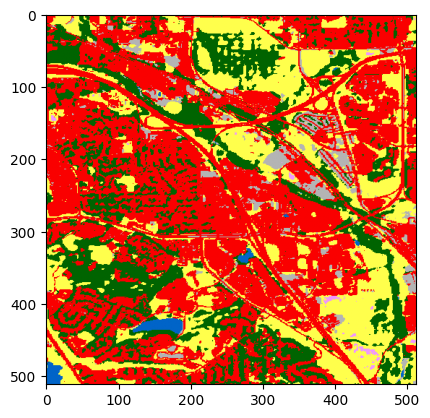

In [7]:
longitude_world = -104.8

latitude_world = 38.8

stac_endopoint = 'https://services.terrascope.be/stac/'

collection_id = 'urn:eop:VITO:ESA_WorldCover_10m_2021_AWS_V2'

bbox = [longitude_world - 0.02135, latitude_world - 0.02135, longitude_world + 0.02135, latitude_world + 0.02135]

client = Client.open(stac_endopoint)

search_results = client.search(
    collections=collection_id,
    bbox=bbox
)

item = search_results.get_all_items()[0]

# this is to tell GDAL we do not need authentication
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

# name of the map asset
asset = 'ESA_WORLDCOVER_10M_MAP'

with STACReader(None, item=item) as stac:
    img = stac.part(bbox, assets=asset)
    
land_use_array = label_to_rgb(img.data[0])


plt.imshow(land_use_array)

### Land use loop

In [14]:
stac_endopoint = 'https://services.terrascope.be/stac/'

collection_id = 'urn:eop:VITO:ESA_WorldCover_10m_2021_AWS_V2'

In [50]:
start_location = 14509 # where you will start your loop based on the dataframe
end_location = 14510  # where you will end your loop based on the dataframe
target_data = []

for index,row in locations.iloc[start_location:end_location].iterrows():
        
    id_ = index
    longitude = row['longitude']
    latitude = row['latitude']
    
    bbox = [longitude - 0.02135, latitude - 0.02135, longitude + 0.02135, latitude + 0.02135]

    client = Client.open(stac_endopoint)

    search_results = client.search(
        collections=collection_id,
        bbox=bbox
    )

    item = search_results.get_all_items()[0]

    # this is to tell GDAL we do not need authentication
    os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

    # name of the map asset
    asset = 'ESA_WORLDCOVER_10M_MAP'

    with STACReader(None, item=item) as stac:
        img = stac.part(bbox, assets=asset)

    land_use_array = label_to_rgb(img.data[0])
    
    target_data.append(land_use_array)
    print(f'at {start_location + len(target_data)} of the arrays')
    
    if len(target_data)%250 == 0:
        target_array = np.array(target_data)
        np.save(f'../raw_data/ESA_worldcover/land_use_data_from_{start_location + len(target_data) - 250}_to_{start_location + len(target_data) - 1}.npy',target_array)
        
        target_data = []
        start_location += 250
        
        continue
    
    
    if start_location + len(target_data) == end_location:
        target_array = np.array(target_data)
        np.save(f'../raw_data/ESA_worldcover/land_use_data_from_{start_location + len(target_data) - 250}_to_{start_location + len(target_data) - 1}.npy',target_array)
        print('Congrats 🎊🎉🥳')
    
    else:
        continue

at 14001 of the arrays
at 14002 of the arrays
at 14003 of the arrays
at 14004 of the arrays
at 14005 of the arrays
at 14006 of the arrays
at 14007 of the arrays
at 14008 of the arrays
at 14009 of the arrays
at 14010 of the arrays
at 14011 of the arrays
at 14012 of the arrays
at 14013 of the arrays
at 14014 of the arrays
at 14015 of the arrays
at 14016 of the arrays
at 14017 of the arrays
at 14018 of the arrays
at 14019 of the arrays
at 14020 of the arrays
at 14021 of the arrays
at 14022 of the arrays
at 14023 of the arrays
at 14024 of the arrays
at 14025 of the arrays
at 14026 of the arrays
at 14027 of the arrays
at 14028 of the arrays
at 14029 of the arrays
at 14030 of the arrays
at 14031 of the arrays
at 14032 of the arrays
at 14033 of the arrays
at 14034 of the arrays
at 14035 of the arrays
at 14036 of the arrays
at 14037 of the arrays
at 14038 of the arrays
at 14039 of the arrays
at 14040 of the arrays
at 14041 of the arrays
at 14042 of the arrays
at 14043 of the arrays
at 14044 of

at 14358 of the arrays
at 14359 of the arrays
at 14360 of the arrays
at 14361 of the arrays
at 14362 of the arrays
at 14363 of the arrays
at 14364 of the arrays
at 14365 of the arrays
at 14366 of the arrays
at 14367 of the arrays
at 14368 of the arrays
at 14369 of the arrays
at 14370 of the arrays
at 14371 of the arrays
at 14372 of the arrays
at 14373 of the arrays
at 14374 of the arrays
at 14375 of the arrays
at 14376 of the arrays
at 14377 of the arrays
at 14378 of the arrays
at 14379 of the arrays
at 14380 of the arrays
at 14381 of the arrays
at 14382 of the arrays
at 14383 of the arrays
at 14384 of the arrays
at 14385 of the arrays
at 14386 of the arrays
at 14387 of the arrays
at 14388 of the arrays
at 14389 of the arrays
at 14390 of the arrays
at 14391 of the arrays
at 14392 of the arrays
at 14393 of the arrays
at 14394 of the arrays
at 14395 of the arrays
at 14396 of the arrays
at 14397 of the arrays
at 14398 of the arrays
at 14399 of the arrays
at 14400 of the arrays
at 14401 of

at 14715 of the arrays
at 14716 of the arrays
at 14717 of the arrays
at 14718 of the arrays
at 14719 of the arrays
at 14720 of the arrays
at 14721 of the arrays
at 14722 of the arrays
at 14723 of the arrays
at 14724 of the arrays
at 14725 of the arrays
at 14726 of the arrays
at 14727 of the arrays
at 14728 of the arrays
at 14729 of the arrays
at 14730 of the arrays
at 14731 of the arrays
at 14732 of the arrays
at 14733 of the arrays
at 14734 of the arrays
at 14735 of the arrays
at 14736 of the arrays
at 14737 of the arrays
at 14738 of the arrays
at 14739 of the arrays
at 14740 of the arrays
at 14741 of the arrays
at 14742 of the arrays
at 14743 of the arrays
at 14744 of the arrays
at 14745 of the arrays
at 14746 of the arrays
at 14747 of the arrays
at 14748 of the arrays
at 14749 of the arrays
at 14750 of the arrays
at 14751 of the arrays
at 14752 of the arrays
at 14753 of the arrays
at 14754 of the arrays
at 14755 of the arrays
at 14756 of the arrays
at 14757 of the arrays
at 14758 of

at 15072 of the arrays
at 15073 of the arrays
at 15074 of the arrays
at 15075 of the arrays
at 15076 of the arrays
at 15077 of the arrays
at 15078 of the arrays
at 15079 of the arrays
at 15080 of the arrays
at 15081 of the arrays
at 15082 of the arrays
at 15083 of the arrays
at 15084 of the arrays
at 15085 of the arrays
at 15086 of the arrays
at 15087 of the arrays
at 15088 of the arrays
at 15089 of the arrays
at 15090 of the arrays
at 15091 of the arrays
at 15092 of the arrays
at 15093 of the arrays
at 15094 of the arrays
at 15095 of the arrays
at 15096 of the arrays
at 15097 of the arrays
at 15098 of the arrays
at 15099 of the arrays
at 15100 of the arrays
at 15101 of the arrays
at 15102 of the arrays
at 15103 of the arrays
at 15104 of the arrays
at 15105 of the arrays
at 15106 of the arrays
at 15107 of the arrays
at 15108 of the arrays
at 15109 of the arrays
at 15110 of the arrays
at 15111 of the arrays
at 15112 of the arrays
at 15113 of the arrays
at 15114 of the arrays
at 15115 of

## NDVI - can I calculate it immediately?

No... pulling pre-calculated NDVI data on Colorado

In [2]:
from PIL import Image

In [146]:
vis_min = 0  # Visualization settings for the image
vis_max = 10_000 # Visualization settings for the image
vis_bands = ['NDVI'] # 
imageDimensions = '512x512' # Set image size: '512x512' for CNN model

id_ = 1

# Import MYD13Q1.061 Aqua Vegetation Indices data
longitude = -106.8
latitude = 39.9

center = ee.Geometry.Point(longitude,latitude)

# Import Sentinel 2 data
s2 = (ee.ImageCollection("MODIS/061/MYD13Q1")
  .filterBounds(center)
  .filterDate('2021-06-01', '2021-07-30')
  .first()
)

# try:
global sentinel_footprint
exportArea = (ee.Geometry.BBox(west=longitude - 0.02135,
                               south=latitude - 0.02135,
                               east=longitude + 0.02135,
                               north=latitude + 0.02135))
# except:
#     print("No Footprint found")
#     continue


s2Vis = {
    'region': exportArea,
    'dimensions': imageDimensions,
    'format': 'png',
    'min': vis_min,
    'max': vis_max,
    'bands': vis_bands
}

s2_url = (s2.getThumbURL(s2Vis))


urllib.request.urlretrieve(s2_url, f"../raw_data/NDVI/image{id_}_{longitude}_{latitude}.png")
print(s2_url)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/77af4995a3b5053f042b4d49c43cf495-3fb22060a2050e7d3b6b069b01aa1300:getPixels


In [147]:
image = Image.open('/Users/timfrith/code/Alastair908/GlobalGreening/raw_data/ndvi/image1_-106.8_39.9.png')

Looping through the csv!

### Year 2002

In [9]:
vis_min = 0  #Visualization settings for the thumbnail
vis_max = 10_000 #Visualization settings for the thumbnail
vis_bands = ['NDVI'] #Includes the bands for RGB 
imageDimensions = '512x512' #Set thumbnail image size (can't be too big, or you run into problems)
start_location = 15414 # where you will start your loop based on the dataframe
end_location = 15416 # where you will end your loop based on the dataframe

for index,row in locations.iloc[start_location:end_location].iterrows():
    id_ = index
    longitude = row['longitude']
    latitude = row['latitude']
    
    center = ee.Geometry.Point(longitude,latitude)

    # Import MYD13Q1.061 Aqua Vegetation Indices data
    ndvi_image = (ee.ImageCollection("MODIS/061/MYD13Q1")
      .filterBounds(center)
      .filterDate('2002-06-01', '2002-07-30')
      .first()
    )

    # try:
    global ndvi_footprint
    exportArea = (ee.Geometry.BBox(west=longitude - 0.02135,
                                   south=latitude - 0.02135,
                                   east=longitude + 0.02135,
                                   north=latitude + 0.02135))
    # except:
    #     print("No Footprint found")
    #     continue


    ndvi_imageVis = {
        'region': exportArea,
        'dimensions': imageDimensions,
        'format': 'png',
        'min': vis_min,
        'max': vis_max,
        'bands': vis_bands
    }

    ndvi_image_url = (ndvi_image.getThumbURL(ndvi_imageVis))


    urllib.request.urlretrieve(ndvi_image_url, f"../raw_data/NDVI_2002/image{id_}_{longitude}_{latitude}.png")
    
    print(f'number {id_} out')

### Year 2006

In [17]:
vis_min = 0  #Visualization settings for the thumbnail
vis_max = 10_000 #Visualization settings for the thumbnail
vis_bands = ['NDVI'] #Includes the bands for RGB 
imageDimensions = '512x512' #Set thumbnail image size (can't be too big, or you run into problems)
start_location = 3466 # where you will start your loop based on the dataframe
end_location = 15416 # where you will end your loop based on the dataframe

for index,row in locations.iloc[start_location:].iterrows():
    id_ = index
    longitude = row['longitude']
    latitude = row['latitude']
    
    center = ee.Geometry.Point(longitude,latitude)

    # Import MYD13Q1.061 Aqua Vegetation Indices data
    ndvi_image = (ee.ImageCollection("MODIS/061/MYD13Q1")
      .filterBounds(center)
      .filterDate('2006-06-01', '2006-07-30')
      .first()
    )

    # try:
    global ndvi_footprint
    exportArea = (ee.Geometry.BBox(west=longitude - 0.02135,
                                   south=latitude - 0.02135,
                                   east=longitude + 0.02135,
                                   north=latitude + 0.02135))
    # except:
    #     print("No Footprint found")
    #     continue


    ndvi_imageVis = {
        'region': exportArea,
        'dimensions': imageDimensions,
        'format': 'png',
        'min': vis_min,
        'max': vis_max,
        'bands': vis_bands
    }

    ndvi_image_url = (ndvi_image.getThumbURL(ndvi_imageVis))


    urllib.request.urlretrieve(ndvi_image_url, f"../raw_data/NDVI_2006/image{id_}_{longitude}_{latitude}.png")
    
    print(f'2006 number {id_} out')

!gsutil -m cp -r ../raw_data/NDVI_2006/ gs://global-greening/

2006 number 3466 out
2006 number 3467 out
2006 number 3468 out
2006 number 3469 out
2006 number 3470 out
2006 number 3471 out
2006 number 3472 out
2006 number 3473 out
2006 number 3474 out
2006 number 3475 out
2006 number 3476 out
2006 number 3477 out
2006 number 3478 out
2006 number 3479 out
2006 number 3480 out
2006 number 3481 out
2006 number 3482 out
2006 number 3483 out
2006 number 3484 out
2006 number 3485 out
2006 number 3486 out
2006 number 3487 out
2006 number 3488 out
2006 number 3489 out
2006 number 3490 out
2006 number 3491 out
2006 number 3492 out
2006 number 3493 out
2006 number 3494 out
2006 number 3495 out
2006 number 3496 out
2006 number 3497 out
2006 number 3498 out
2006 number 3499 out
2006 number 3500 out
2006 number 3501 out
2006 number 3502 out
2006 number 3503 out
2006 number 3504 out
2006 number 3505 out
2006 number 3506 out
2006 number 3507 out
2006 number 3508 out
2006 number 3509 out
2006 number 3510 out
2006 number 3511 out
2006 number 3512 out
2006 number 3

2006 number 3857 out
2006 number 3858 out
2006 number 3859 out
2006 number 3860 out
2006 number 3861 out
2006 number 3862 out
2006 number 3863 out
2006 number 3864 out
2006 number 3865 out
2006 number 3866 out
2006 number 3867 out
2006 number 3868 out
2006 number 3869 out
2006 number 3870 out
2006 number 3871 out
2006 number 3872 out
2006 number 3873 out
2006 number 3874 out
2006 number 3875 out
2006 number 3876 out
2006 number 3877 out
2006 number 3878 out
2006 number 3879 out
2006 number 3880 out
2006 number 3881 out
2006 number 3882 out
2006 number 3883 out
2006 number 3884 out
2006 number 3885 out
2006 number 3886 out
2006 number 3887 out
2006 number 3888 out
2006 number 3889 out
2006 number 3890 out
2006 number 3891 out
2006 number 3892 out
2006 number 3893 out
2006 number 3894 out
2006 number 3895 out
2006 number 3896 out
2006 number 3897 out
2006 number 3898 out
2006 number 3899 out
2006 number 3900 out
2006 number 3901 out
2006 number 3902 out
2006 number 3903 out
2006 number 3

2006 number 4248 out
2006 number 4249 out
2006 number 4250 out
2006 number 4251 out
2006 number 4252 out
2006 number 4253 out
2006 number 4254 out
2006 number 4255 out
2006 number 4256 out
2006 number 4257 out
2006 number 4258 out
2006 number 4259 out
2006 number 4260 out
2006 number 4261 out
2006 number 4262 out
2006 number 4263 out
2006 number 4264 out
2006 number 4265 out
2006 number 4266 out
2006 number 4267 out
2006 number 4268 out
2006 number 4269 out
2006 number 4270 out
2006 number 4271 out
2006 number 4272 out
2006 number 4273 out
2006 number 4274 out
2006 number 4275 out
2006 number 4276 out
2006 number 4277 out
2006 number 4278 out
2006 number 4279 out
2006 number 4280 out
2006 number 4281 out
2006 number 4282 out
2006 number 4283 out
2006 number 4284 out
2006 number 4285 out
2006 number 4286 out
2006 number 4287 out
2006 number 4288 out
2006 number 4289 out
2006 number 4290 out
2006 number 4291 out
2006 number 4292 out
2006 number 4293 out
2006 number 4294 out
2006 number 4

2006 number 4639 out
2006 number 4640 out
2006 number 4641 out
2006 number 4642 out
2006 number 4643 out
2006 number 4644 out
2006 number 4645 out
2006 number 4646 out
2006 number 4647 out
2006 number 4648 out
2006 number 4649 out
2006 number 4650 out
2006 number 4651 out
2006 number 4652 out
2006 number 4653 out
2006 number 4654 out
2006 number 4655 out
2006 number 4656 out
2006 number 4657 out
2006 number 4658 out
2006 number 4659 out
2006 number 4660 out
2006 number 4661 out
2006 number 4662 out
2006 number 4663 out
2006 number 4664 out
2006 number 4665 out
2006 number 4666 out
2006 number 4667 out
2006 number 4668 out
2006 number 4669 out
2006 number 4670 out
2006 number 4671 out
2006 number 4672 out
2006 number 4673 out
2006 number 4674 out
2006 number 4675 out
2006 number 4676 out
2006 number 4677 out
2006 number 4678 out
2006 number 4679 out
2006 number 4680 out
2006 number 4681 out
2006 number 4682 out
2006 number 4683 out
2006 number 4684 out
2006 number 4685 out
2006 number 4

2006 number 5030 out
2006 number 5031 out
2006 number 5032 out
2006 number 5033 out
2006 number 5034 out
2006 number 5035 out
2006 number 5036 out
2006 number 5037 out
2006 number 5038 out
2006 number 5039 out
2006 number 5040 out
2006 number 5041 out
2006 number 5042 out
2006 number 5043 out
2006 number 5044 out
2006 number 5045 out
2006 number 5046 out
2006 number 5047 out
2006 number 5048 out
2006 number 5049 out
2006 number 5050 out
2006 number 5051 out
2006 number 5052 out
2006 number 5053 out
2006 number 5054 out
2006 number 5055 out
2006 number 5056 out
2006 number 5057 out
2006 number 5058 out
2006 number 5059 out
2006 number 5060 out
2006 number 5061 out
2006 number 5062 out
2006 number 5063 out
2006 number 5064 out
2006 number 5065 out
2006 number 5066 out
2006 number 5067 out
2006 number 5068 out
2006 number 5069 out
2006 number 5070 out
2006 number 5071 out
2006 number 5072 out
2006 number 5073 out
2006 number 5074 out
2006 number 5075 out
2006 number 5076 out
2006 number 5

2006 number 5421 out
2006 number 5422 out
2006 number 5423 out
2006 number 5424 out
2006 number 5425 out
2006 number 5426 out
2006 number 5427 out
2006 number 5428 out
2006 number 5429 out
2006 number 5430 out
2006 number 5431 out
2006 number 5432 out
2006 number 5433 out
2006 number 5434 out
2006 number 5435 out
2006 number 5436 out
2006 number 5437 out
2006 number 5438 out
2006 number 5439 out
2006 number 5440 out
2006 number 5441 out
2006 number 5442 out
2006 number 5443 out
2006 number 5444 out
2006 number 5445 out
2006 number 5446 out
2006 number 5447 out
2006 number 5448 out
2006 number 5449 out
2006 number 5450 out
2006 number 5451 out
2006 number 5452 out
2006 number 5453 out
2006 number 5454 out
2006 number 5455 out
2006 number 5456 out
2006 number 5457 out
2006 number 5458 out
2006 number 5459 out
2006 number 5460 out
2006 number 5461 out
2006 number 5462 out
2006 number 5463 out
2006 number 5464 out
2006 number 5465 out
2006 number 5466 out
2006 number 5467 out
2006 number 5

2006 number 5812 out
2006 number 5813 out
2006 number 5814 out
2006 number 5815 out
2006 number 5816 out
2006 number 5817 out
2006 number 5818 out
2006 number 5819 out
2006 number 5820 out
2006 number 5821 out
2006 number 5822 out
2006 number 5823 out
2006 number 5824 out
2006 number 5825 out
2006 number 5826 out
2006 number 5827 out
2006 number 5828 out
2006 number 5829 out
2006 number 5830 out
2006 number 5831 out
2006 number 5832 out
2006 number 5833 out
2006 number 5834 out
2006 number 5835 out
2006 number 5836 out
2006 number 5837 out
2006 number 5838 out
2006 number 5839 out
2006 number 5840 out
2006 number 5841 out
2006 number 5842 out
2006 number 5843 out
2006 number 5844 out
2006 number 5845 out
2006 number 5846 out
2006 number 5847 out
2006 number 5848 out
2006 number 5849 out
2006 number 5850 out
2006 number 5851 out
2006 number 5852 out
2006 number 5853 out
2006 number 5854 out
2006 number 5855 out
2006 number 5856 out
2006 number 5857 out
2006 number 5858 out
2006 number 5

2006 number 6203 out
2006 number 6204 out
2006 number 6205 out
2006 number 6206 out
2006 number 6207 out
2006 number 6208 out
2006 number 6209 out
2006 number 6210 out
2006 number 6211 out
2006 number 6212 out
2006 number 6213 out
2006 number 6214 out
2006 number 6215 out
2006 number 6216 out
2006 number 6217 out
2006 number 6218 out
2006 number 6219 out
2006 number 6220 out
2006 number 6221 out
2006 number 6222 out
2006 number 6223 out
2006 number 6224 out
2006 number 6225 out
2006 number 6226 out
2006 number 6227 out
2006 number 6228 out
2006 number 6229 out
2006 number 6230 out
2006 number 6231 out
2006 number 6232 out
2006 number 6233 out
2006 number 6234 out
2006 number 6235 out
2006 number 6236 out
2006 number 6237 out
2006 number 6238 out
2006 number 6239 out
2006 number 6240 out
2006 number 6241 out
2006 number 6242 out
2006 number 6243 out
2006 number 6244 out
2006 number 6245 out
2006 number 6246 out
2006 number 6247 out
2006 number 6248 out
2006 number 6249 out
2006 number 6

2006 number 6594 out
2006 number 6595 out
2006 number 6596 out
2006 number 6597 out
2006 number 6598 out
2006 number 6599 out
2006 number 6600 out
2006 number 6601 out
2006 number 6602 out
2006 number 6603 out
2006 number 6604 out
2006 number 6605 out
2006 number 6606 out
2006 number 6607 out
2006 number 6608 out
2006 number 6609 out
2006 number 6610 out
2006 number 6611 out
2006 number 6612 out
2006 number 6613 out
2006 number 6614 out
2006 number 6615 out
2006 number 6616 out
2006 number 6617 out
2006 number 6618 out
2006 number 6619 out
2006 number 6620 out
2006 number 6621 out
2006 number 6622 out
2006 number 6623 out
2006 number 6624 out
2006 number 6625 out
2006 number 6626 out
2006 number 6627 out
2006 number 6628 out
2006 number 6629 out
2006 number 6630 out
2006 number 6631 out
2006 number 6632 out
2006 number 6633 out
2006 number 6634 out
2006 number 6635 out
2006 number 6636 out
2006 number 6637 out
2006 number 6638 out
2006 number 6639 out
2006 number 6640 out
2006 number 6

2006 number 6985 out
2006 number 6986 out
2006 number 6987 out
2006 number 6988 out
2006 number 6989 out
2006 number 6990 out
2006 number 6991 out
2006 number 6992 out
2006 number 6993 out
2006 number 6994 out
2006 number 6995 out
2006 number 6996 out
2006 number 6997 out
2006 number 6998 out
2006 number 6999 out
2006 number 7000 out
2006 number 7001 out
2006 number 7002 out
2006 number 7003 out
2006 number 7004 out
2006 number 7005 out
2006 number 7006 out
2006 number 7007 out
2006 number 7008 out
2006 number 7009 out
2006 number 7010 out
2006 number 7011 out
2006 number 7012 out
2006 number 7013 out
2006 number 7014 out
2006 number 7015 out
2006 number 7016 out
2006 number 7017 out
2006 number 7018 out
2006 number 7019 out
2006 number 7020 out
2006 number 7021 out
2006 number 7022 out
2006 number 7023 out
2006 number 7024 out
2006 number 7025 out
2006 number 7026 out
2006 number 7027 out
2006 number 7028 out
2006 number 7029 out
2006 number 7030 out
2006 number 7031 out
2006 number 7

2006 number 7376 out
2006 number 7377 out
2006 number 7378 out
2006 number 7379 out
2006 number 7380 out
2006 number 7381 out
2006 number 7382 out
2006 number 7383 out
2006 number 7384 out
2006 number 7385 out
2006 number 7386 out
2006 number 7387 out
2006 number 7388 out
2006 number 7389 out
2006 number 7390 out
2006 number 7391 out
2006 number 7392 out
2006 number 7393 out
2006 number 7394 out
2006 number 7395 out
2006 number 7396 out
2006 number 7397 out
2006 number 7398 out
2006 number 7399 out
2006 number 7400 out
2006 number 7401 out
2006 number 7402 out
2006 number 7403 out
2006 number 7404 out
2006 number 7405 out
2006 number 7406 out
2006 number 7407 out
2006 number 7408 out
2006 number 7409 out
2006 number 7410 out
2006 number 7411 out
2006 number 7412 out
2006 number 7413 out
2006 number 7414 out
2006 number 7415 out
2006 number 7416 out
2006 number 7417 out
2006 number 7418 out
2006 number 7419 out
2006 number 7420 out
2006 number 7421 out
2006 number 7422 out
2006 number 7

2006 number 7767 out
2006 number 7768 out
2006 number 7769 out
2006 number 7770 out
2006 number 7771 out
2006 number 7772 out
2006 number 7773 out
2006 number 7774 out
2006 number 7775 out
2006 number 7776 out
2006 number 7777 out
2006 number 7778 out
2006 number 7779 out
2006 number 7780 out
2006 number 7781 out
2006 number 7782 out
2006 number 7783 out
2006 number 7784 out
2006 number 7785 out
2006 number 7786 out
2006 number 7787 out
2006 number 7788 out
2006 number 7789 out
2006 number 7790 out
2006 number 7791 out
2006 number 7792 out
2006 number 7793 out
2006 number 7794 out
2006 number 7795 out
2006 number 7796 out
2006 number 7797 out
2006 number 7798 out
2006 number 7799 out
2006 number 7800 out
2006 number 7801 out
2006 number 7802 out
2006 number 7803 out
2006 number 7804 out
2006 number 7805 out
2006 number 7806 out
2006 number 7807 out
2006 number 7808 out
2006 number 7809 out
2006 number 7810 out
2006 number 7811 out
2006 number 7812 out
2006 number 7813 out
2006 number 7

2006 number 8159 out
2006 number 8160 out
2006 number 8161 out
2006 number 8162 out
2006 number 8163 out
2006 number 8164 out
2006 number 8165 out
2006 number 8166 out
2006 number 8167 out
2006 number 8168 out
2006 number 8169 out
2006 number 8170 out
2006 number 8171 out
2006 number 8172 out
2006 number 8173 out
2006 number 8174 out
2006 number 8175 out
2006 number 8176 out
2006 number 8177 out
2006 number 8178 out
2006 number 8179 out
2006 number 8180 out
2006 number 8181 out
2006 number 8182 out
2006 number 8183 out
2006 number 8184 out
2006 number 8185 out
2006 number 8186 out
2006 number 8187 out
2006 number 8188 out
2006 number 8189 out
2006 number 8190 out
2006 number 8191 out
2006 number 8192 out
2006 number 8193 out
2006 number 8194 out
2006 number 8195 out
2006 number 8196 out
2006 number 8197 out
2006 number 8198 out
2006 number 8199 out
2006 number 8200 out
2006 number 8201 out
2006 number 8202 out
2006 number 8203 out
2006 number 8204 out
2006 number 8205 out
2006 number 8

2006 number 8550 out
2006 number 8551 out
2006 number 8552 out
2006 number 8553 out
2006 number 8554 out
2006 number 8555 out
2006 number 8556 out
2006 number 8557 out
2006 number 8558 out
2006 number 8559 out
2006 number 8560 out
2006 number 8561 out
2006 number 8562 out
2006 number 8563 out
2006 number 8564 out
2006 number 8565 out
2006 number 8566 out
2006 number 8567 out
2006 number 8568 out
2006 number 8569 out
2006 number 8570 out
2006 number 8571 out
2006 number 8572 out
2006 number 8573 out
2006 number 8574 out
2006 number 8575 out
2006 number 8576 out
2006 number 8577 out
2006 number 8578 out
2006 number 8579 out
2006 number 8580 out
2006 number 8581 out
2006 number 8582 out
2006 number 8583 out
2006 number 8584 out
2006 number 8585 out
2006 number 8586 out
2006 number 8587 out
2006 number 8588 out
2006 number 8589 out
2006 number 8590 out
2006 number 8591 out
2006 number 8592 out
2006 number 8593 out
2006 number 8594 out
2006 number 8595 out
2006 number 8596 out
2006 number 8

2006 number 8941 out
2006 number 8942 out
2006 number 8943 out
2006 number 8944 out
2006 number 8945 out
2006 number 8946 out
2006 number 8947 out
2006 number 8948 out
2006 number 8949 out
2006 number 8950 out
2006 number 8951 out
2006 number 8952 out
2006 number 8953 out
2006 number 8954 out
2006 number 8955 out
2006 number 8956 out
2006 number 8957 out
2006 number 8958 out
2006 number 8959 out
2006 number 8960 out
2006 number 8961 out
2006 number 8962 out
2006 number 8963 out
2006 number 8964 out
2006 number 8965 out
2006 number 8966 out
2006 number 8967 out
2006 number 8968 out
2006 number 8969 out
2006 number 8970 out
2006 number 8971 out
2006 number 8972 out
2006 number 8973 out
2006 number 8974 out
2006 number 8975 out
2006 number 8976 out
2006 number 8977 out
2006 number 8978 out
2006 number 8979 out
2006 number 8980 out
2006 number 8981 out
2006 number 8982 out
2006 number 8983 out
2006 number 8984 out
2006 number 8985 out
2006 number 8986 out
2006 number 8987 out
2006 number 8

2006 number 9332 out
2006 number 9333 out
2006 number 9334 out
2006 number 9335 out
2006 number 9336 out
2006 number 9337 out
2006 number 9338 out
2006 number 9339 out
2006 number 9340 out
2006 number 9341 out
2006 number 9342 out
2006 number 9343 out
2006 number 9344 out
2006 number 9345 out
2006 number 9346 out
2006 number 9347 out
2006 number 9348 out
2006 number 9349 out
2006 number 9350 out
2006 number 9351 out
2006 number 9352 out
2006 number 9353 out
2006 number 9354 out
2006 number 9355 out
2006 number 9356 out
2006 number 9357 out
2006 number 9358 out
2006 number 9359 out
2006 number 9360 out
2006 number 9361 out
2006 number 9362 out
2006 number 9363 out
2006 number 9364 out
2006 number 9365 out
2006 number 9366 out
2006 number 9367 out
2006 number 9368 out
2006 number 9369 out
2006 number 9370 out
2006 number 9371 out
2006 number 9372 out
2006 number 9373 out
2006 number 9374 out
2006 number 9375 out
2006 number 9376 out
2006 number 9377 out
2006 number 9378 out
2006 number 9

2006 number 9723 out
2006 number 9724 out
2006 number 9725 out
2006 number 9726 out
2006 number 9727 out
2006 number 9728 out
2006 number 9729 out
2006 number 9730 out
2006 number 9731 out
2006 number 9732 out
2006 number 9733 out
2006 number 9734 out
2006 number 9735 out
2006 number 9736 out
2006 number 9737 out
2006 number 9738 out
2006 number 9739 out
2006 number 9740 out
2006 number 9741 out
2006 number 9742 out
2006 number 9743 out
2006 number 9744 out
2006 number 9745 out
2006 number 9746 out
2006 number 9747 out
2006 number 9748 out
2006 number 9749 out
2006 number 9750 out
2006 number 9751 out
2006 number 9752 out
2006 number 9753 out
2006 number 9754 out
2006 number 9755 out
2006 number 9756 out
2006 number 9757 out
2006 number 9758 out
2006 number 9759 out
2006 number 9760 out
2006 number 9761 out
2006 number 9762 out
2006 number 9763 out
2006 number 9764 out
2006 number 9765 out
2006 number 9766 out
2006 number 9767 out
2006 number 9768 out
2006 number 9769 out
2006 number 9

2006 number 10108 out
2006 number 10109 out
2006 number 10110 out
2006 number 10111 out
2006 number 10112 out
2006 number 10113 out
2006 number 10114 out
2006 number 10115 out
2006 number 10116 out
2006 number 10117 out
2006 number 10118 out
2006 number 10119 out
2006 number 10120 out
2006 number 10121 out
2006 number 10122 out
2006 number 10123 out
2006 number 10124 out
2006 number 10125 out
2006 number 10126 out
2006 number 10127 out
2006 number 10128 out
2006 number 10129 out
2006 number 10130 out
2006 number 10131 out
2006 number 10132 out
2006 number 10133 out
2006 number 10134 out
2006 number 10135 out
2006 number 10136 out
2006 number 10137 out
2006 number 10138 out
2006 number 10139 out
2006 number 10140 out
2006 number 10141 out
2006 number 10142 out
2006 number 10143 out
2006 number 10144 out
2006 number 10145 out
2006 number 10146 out
2006 number 10147 out
2006 number 10148 out
2006 number 10149 out
2006 number 10150 out
2006 number 10151 out
2006 number 10152 out
2006 numbe

### Year 2010

In [18]:
vis_min = 0  #Visualization settings for the thumbnail
vis_max = 10_000 #Visualization settings for the thumbnail
vis_bands = ['NDVI'] #Includes the bands for RGB 
imageDimensions = '512x512' #Set thumbnail image size (can't be too big, or you run into problems)
start_location = 0 # where you will start your loop based on the dataframe
end_location = 15416 # where you will end your loop based on the dataframe

for index,row in locations.iloc[start_location:].iterrows():
    id_ = index
    longitude = row['longitude']
    latitude = row['latitude']
    
    center = ee.Geometry.Point(longitude,latitude)

    # Import MYD13Q1.061 Aqua Vegetation Indices data
    ndvi_image = (ee.ImageCollection("MODIS/061/MYD13Q1")
      .filterBounds(center)
      .filterDate('2010-06-01', '2010-07-30')
      .first()
    )

    # try:
    global ndvi_footprint
    exportArea = (ee.Geometry.BBox(west=longitude - 0.02135,
                                   south=latitude - 0.02135,
                                   east=longitude + 0.02135,
                                   north=latitude + 0.02135))
    # except:
    #     print("No Footprint found")
    #     continue


    ndvi_imageVis = {
        'region': exportArea,
        'dimensions': imageDimensions,
        'format': 'png',
        'min': vis_min,
        'max': vis_max,
        'bands': vis_bands
    }

    ndvi_image_url = (ndvi_image.getThumbURL(ndvi_imageVis))


    urllib.request.urlretrieve(ndvi_image_url, f"../raw_data/NDVI_2010/image{id_}_{longitude}_{latitude}.png")
    
    print(f'2010 number {id_} out')
!gsutil -m cp -r ../raw_data/NDVI_2010/ gs://global-greening/

### Year 2014

In [5]:
vis_min = 0  #Visualization settings for the thumbnail
vis_max = 10_000 #Visualization settings for the thumbnail
vis_bands = ['NDVI'] #Includes the bands for RGB 
imageDimensions = '512x512' #Set thumbnail image size (can't be too big, or you run into problems)
start_location = 5558 # where you will start your loop based on the dataframe
end_location = 15416 # where you will end your loop based on the dataframe

for index,row in locations.iloc[start_location:end_location].iterrows():
    id_ = index
    longitude = row['longitude']
    latitude = row['latitude']
    
    center = ee.Geometry.Point(longitude,latitude)

    # Import MYD13Q1.061 Aqua Vegetation Indices data
    ndvi_image = (ee.ImageCollection("MODIS/061/MYD13Q1")
      .filterBounds(center)
      .filterDate('2014-06-01', '2014-07-30')
      .first()
    )

    # try:
    global ndvi_footprint
    exportArea = (ee.Geometry.BBox(west=longitude - 0.02135,
                                   south=latitude - 0.02135,
                                   east=longitude + 0.02135,
                                   north=latitude + 0.02135))
    # except:
    #     print("No Footprint found")
    #     continue


    ndvi_imageVis = {
        'region': exportArea,
        'dimensions': imageDimensions,
        'format': 'png',
        'min': vis_min,
        'max': vis_max,
        'bands': vis_bands
    }

    ndvi_image_url = (ndvi_image.getThumbURL(ndvi_imageVis))


    urllib.request.urlretrieve(ndvi_image_url, f"../raw_data/NDVI_2014/image{id_}_{longitude}_{latitude}.png")
    
    print(f'2014 number {id_} out')


!gsutil -m cp -r ../raw_data/NDVI_2014/ gs://global-greening/

2014 number 5558 out
2014 number 5559 out
2014 number 5560 out
2014 number 5561 out
2014 number 5562 out
2014 number 5563 out
2014 number 5564 out
2014 number 5565 out
2014 number 5566 out
2014 number 5567 out
2014 number 5568 out
2014 number 5569 out
2014 number 5570 out
2014 number 5571 out
2014 number 5572 out
2014 number 5573 out
2014 number 5574 out
2014 number 5575 out
2014 number 5576 out
2014 number 5577 out
2014 number 5578 out
2014 number 5579 out
2014 number 5580 out
2014 number 5581 out
2014 number 5582 out
2014 number 5583 out
2014 number 5584 out
2014 number 5585 out
2014 number 5586 out
2014 number 5587 out
2014 number 5588 out
2014 number 5589 out
2014 number 5590 out
2014 number 5591 out
2014 number 5592 out
2014 number 5593 out
2014 number 5594 out
2014 number 5595 out
2014 number 5596 out
2014 number 5597 out
2014 number 5598 out
2014 number 5599 out
2014 number 5600 out
2014 number 5601 out
2014 number 5602 out
2014 number 5603 out
2014 number 5604 out
2014 number 5

2014 number 5949 out
2014 number 5950 out
2014 number 5951 out
2014 number 5952 out
2014 number 5953 out
2014 number 5954 out
2014 number 5955 out
2014 number 5956 out
2014 number 5957 out
2014 number 5958 out
2014 number 5959 out
2014 number 5960 out
2014 number 5961 out
2014 number 5962 out
2014 number 5963 out
2014 number 5964 out
2014 number 5965 out
2014 number 5966 out
2014 number 5967 out
2014 number 5968 out
2014 number 5969 out
2014 number 5970 out
2014 number 5971 out
2014 number 5972 out
2014 number 5973 out
2014 number 5974 out
2014 number 5975 out
2014 number 5976 out
2014 number 5977 out
2014 number 5978 out
2014 number 5979 out
2014 number 5980 out
2014 number 5981 out
2014 number 5982 out
2014 number 5983 out
2014 number 5984 out
2014 number 5985 out
2014 number 5986 out
2014 number 5987 out
2014 number 5988 out
2014 number 5989 out
2014 number 5990 out
2014 number 5991 out
2014 number 5992 out
2014 number 5993 out
2014 number 5994 out
2014 number 5995 out
2014 number 5

2014 number 6340 out
2014 number 6341 out
2014 number 6342 out
2014 number 6343 out
2014 number 6344 out
2014 number 6345 out
2014 number 6346 out
2014 number 6347 out
2014 number 6348 out
2014 number 6349 out
2014 number 6350 out
2014 number 6351 out
2014 number 6352 out
2014 number 6353 out
2014 number 6354 out
2014 number 6355 out
2014 number 6356 out
2014 number 6357 out
2014 number 6358 out
2014 number 6359 out
2014 number 6360 out
2014 number 6361 out
2014 number 6362 out
2014 number 6363 out
2014 number 6364 out
2014 number 6365 out
2014 number 6366 out
2014 number 6367 out
2014 number 6368 out
2014 number 6369 out
2014 number 6370 out
2014 number 6371 out
2014 number 6372 out
2014 number 6373 out
2014 number 6374 out
2014 number 6375 out
2014 number 6376 out
2014 number 6377 out
2014 number 6378 out
2014 number 6379 out
2014 number 6380 out
2014 number 6381 out
2014 number 6382 out
2014 number 6383 out
2014 number 6384 out
2014 number 6385 out
2014 number 6386 out
2014 number 6

2014 number 6731 out
2014 number 6732 out
2014 number 6733 out
2014 number 6734 out
2014 number 6735 out
2014 number 6736 out
2014 number 6737 out
2014 number 6738 out
2014 number 6739 out
2014 number 6740 out
2014 number 6741 out
2014 number 6742 out
2014 number 6743 out
2014 number 6744 out
2014 number 6745 out
2014 number 6746 out
2014 number 6747 out
2014 number 6748 out
2014 number 6749 out
2014 number 6750 out
2014 number 6751 out
2014 number 6752 out
2014 number 6753 out
2014 number 6754 out
2014 number 6755 out
2014 number 6756 out
2014 number 6757 out
2014 number 6758 out
2014 number 6759 out
2014 number 6760 out
2014 number 6761 out
2014 number 6762 out
2014 number 6763 out
2014 number 6764 out
2014 number 6765 out
2014 number 6766 out
2014 number 6767 out
2014 number 6768 out
2014 number 6769 out
2014 number 6770 out
2014 number 6771 out
2014 number 6772 out
2014 number 6773 out
2014 number 6774 out
2014 number 6775 out
2014 number 6776 out
2014 number 6777 out
2014 number 6

2014 number 7122 out
2014 number 7123 out
2014 number 7124 out
2014 number 7125 out
2014 number 7126 out
2014 number 7127 out
2014 number 7128 out
2014 number 7129 out
2014 number 7130 out
2014 number 7131 out
2014 number 7132 out
2014 number 7133 out
2014 number 7134 out
2014 number 7135 out
2014 number 7136 out
2014 number 7137 out
2014 number 7138 out
2014 number 7139 out
2014 number 7140 out
2014 number 7141 out
2014 number 7142 out
2014 number 7143 out
2014 number 7144 out
2014 number 7145 out
2014 number 7146 out
2014 number 7147 out
2014 number 7148 out
2014 number 7149 out
2014 number 7150 out
2014 number 7151 out
2014 number 7152 out
2014 number 7153 out
2014 number 7154 out
2014 number 7155 out
2014 number 7156 out
2014 number 7157 out
2014 number 7158 out
2014 number 7159 out
2014 number 7160 out
2014 number 7161 out
2014 number 7162 out
2014 number 7163 out
2014 number 7164 out
2014 number 7165 out
2014 number 7166 out
2014 number 7167 out
2014 number 7168 out
2014 number 7

2014 number 7513 out
2014 number 7514 out
2014 number 7515 out
2014 number 7516 out
2014 number 7517 out
2014 number 7518 out
2014 number 7519 out
2014 number 7520 out
2014 number 7521 out
2014 number 7522 out
2014 number 7523 out
2014 number 7524 out
2014 number 7525 out
2014 number 7526 out
2014 number 7527 out
2014 number 7528 out
2014 number 7529 out
2014 number 7530 out
2014 number 7531 out
2014 number 7532 out
2014 number 7533 out
2014 number 7534 out
2014 number 7535 out
2014 number 7536 out
2014 number 7537 out
2014 number 7538 out
2014 number 7539 out
2014 number 7540 out
2014 number 7541 out
2014 number 7542 out
2014 number 7543 out
2014 number 7544 out
2014 number 7545 out
2014 number 7546 out
2014 number 7547 out
2014 number 7548 out
2014 number 7549 out
2014 number 7550 out
2014 number 7551 out
2014 number 7552 out
2014 number 7553 out
2014 number 7554 out
2014 number 7555 out
2014 number 7556 out
2014 number 7557 out
2014 number 7558 out
2014 number 7559 out
2014 number 7

2014 number 7903 out
2014 number 7904 out
2014 number 7905 out
2014 number 7906 out
2014 number 7907 out
2014 number 7908 out
2014 number 7909 out
2014 number 7910 out
2014 number 7911 out
2014 number 7912 out
2014 number 7913 out
2014 number 7914 out
2014 number 7915 out
2014 number 7916 out
2014 number 7917 out
2014 number 7918 out
2014 number 7919 out
2014 number 7920 out
2014 number 7921 out
2014 number 7922 out
2014 number 7923 out
2014 number 7924 out
2014 number 7925 out
2014 number 7926 out
2014 number 7927 out
2014 number 7928 out
2014 number 7929 out
2014 number 7930 out
2014 number 7931 out
2014 number 7932 out
2014 number 7933 out
2014 number 7934 out
2014 number 7935 out
2014 number 7936 out
2014 number 7937 out
2014 number 7938 out
2014 number 7939 out
2014 number 7940 out
2014 number 7941 out
2014 number 7942 out
2014 number 7943 out
2014 number 7944 out
2014 number 7945 out
2014 number 7946 out
2014 number 7947 out
2014 number 7948 out
2014 number 7949 out
2014 number 7

2014 number 8294 out
2014 number 8295 out
2014 number 8296 out
2014 number 8297 out
2014 number 8298 out
2014 number 8299 out
2014 number 8300 out
2014 number 8301 out
2014 number 8302 out
2014 number 8303 out
2014 number 8304 out
2014 number 8305 out
2014 number 8306 out
2014 number 8307 out
2014 number 8308 out
2014 number 8309 out
2014 number 8310 out
2014 number 8311 out
2014 number 8312 out
2014 number 8313 out
2014 number 8314 out
2014 number 8315 out
2014 number 8316 out
2014 number 8317 out
2014 number 8318 out
2014 number 8319 out
2014 number 8320 out
2014 number 8321 out
2014 number 8322 out
2014 number 8323 out
2014 number 8324 out
2014 number 8325 out
2014 number 8326 out
2014 number 8327 out
2014 number 8328 out
2014 number 8329 out
2014 number 8330 out
2014 number 8331 out
2014 number 8332 out
2014 number 8333 out
2014 number 8334 out
2014 number 8335 out
2014 number 8336 out
2014 number 8337 out
2014 number 8338 out
2014 number 8339 out
2014 number 8340 out
2014 number 8

2014 number 8685 out
2014 number 8686 out
2014 number 8687 out
2014 number 8688 out
2014 number 8689 out
2014 number 8690 out
2014 number 8691 out
2014 number 8692 out
2014 number 8693 out
2014 number 8694 out
2014 number 8695 out
2014 number 8696 out
2014 number 8697 out
2014 number 8698 out
2014 number 8699 out
2014 number 8700 out
2014 number 8701 out
2014 number 8702 out
2014 number 8703 out
2014 number 8704 out
2014 number 8705 out
2014 number 8706 out
2014 number 8707 out
2014 number 8708 out
2014 number 8709 out
2014 number 8710 out
2014 number 8711 out
2014 number 8712 out
2014 number 8713 out
2014 number 8714 out
2014 number 8715 out
2014 number 8716 out
2014 number 8717 out
2014 number 8718 out
2014 number 8719 out
2014 number 8720 out
2014 number 8721 out
2014 number 8722 out
2014 number 8723 out
2014 number 8724 out
2014 number 8725 out
2014 number 8726 out
2014 number 8727 out
2014 number 8728 out
2014 number 8729 out
2014 number 8730 out
2014 number 8731 out
2014 number 8

2014 number 9076 out
2014 number 9077 out
2014 number 9078 out
2014 number 9079 out
2014 number 9080 out
2014 number 9081 out
2014 number 9082 out
2014 number 9083 out
2014 number 9084 out
2014 number 9085 out
2014 number 9086 out
2014 number 9087 out
2014 number 9088 out
2014 number 9089 out
2014 number 9090 out
2014 number 9091 out
2014 number 9092 out
2014 number 9093 out
2014 number 9094 out
2014 number 9095 out
2014 number 9096 out
2014 number 9097 out
2014 number 9098 out
2014 number 9099 out
2014 number 9100 out
2014 number 9101 out
2014 number 9102 out
2014 number 9103 out
2014 number 9104 out
2014 number 9105 out
2014 number 9106 out
2014 number 9107 out
2014 number 9108 out
2014 number 9109 out
2014 number 9110 out
2014 number 9111 out
2014 number 9112 out
2014 number 9113 out
2014 number 9114 out
2014 number 9115 out
2014 number 9116 out
2014 number 9117 out
2014 number 9118 out
2014 number 9119 out
2014 number 9120 out
2014 number 9121 out
2014 number 9122 out
2014 number 9

2014 number 9467 out
2014 number 9468 out
2014 number 9469 out
2014 number 9470 out
2014 number 9471 out
2014 number 9472 out
2014 number 9473 out
2014 number 9474 out
2014 number 9475 out
2014 number 9476 out
2014 number 9477 out
2014 number 9478 out
2014 number 9479 out
2014 number 9480 out
2014 number 9481 out
2014 number 9482 out
2014 number 9483 out
2014 number 9484 out
2014 number 9485 out
2014 number 9486 out
2014 number 9487 out
2014 number 9488 out
2014 number 9489 out
2014 number 9490 out
2014 number 9491 out
2014 number 9492 out
2014 number 9493 out
2014 number 9494 out
2014 number 9495 out
2014 number 9496 out
2014 number 9497 out
2014 number 9498 out
2014 number 9499 out
2014 number 9500 out
2014 number 9501 out
2014 number 9502 out
2014 number 9503 out
2014 number 9504 out
2014 number 9505 out
2014 number 9506 out
2014 number 9507 out
2014 number 9508 out
2014 number 9509 out
2014 number 9510 out
2014 number 9511 out
2014 number 9512 out
2014 number 9513 out
2014 number 9

2014 number 9858 out
2014 number 9859 out
2014 number 9860 out
2014 number 9861 out
2014 number 9862 out
2014 number 9863 out
2014 number 9864 out
2014 number 9865 out
2014 number 9866 out
2014 number 9867 out
2014 number 9868 out
2014 number 9869 out
2014 number 9870 out
2014 number 9871 out
2014 number 9872 out
2014 number 9873 out
2014 number 9874 out
2014 number 9875 out
2014 number 9876 out
2014 number 9877 out
2014 number 9878 out
2014 number 9879 out
2014 number 9880 out
2014 number 9881 out
2014 number 9882 out
2014 number 9883 out
2014 number 9884 out
2014 number 9885 out
2014 number 9886 out
2014 number 9887 out
2014 number 9888 out
2014 number 9889 out
2014 number 9890 out
2014 number 9891 out
2014 number 9892 out
2014 number 9893 out
2014 number 9894 out
2014 number 9895 out
2014 number 9896 out
2014 number 9897 out
2014 number 9898 out
2014 number 9899 out
2014 number 9900 out
2014 number 9901 out
2014 number 9902 out
2014 number 9903 out
2014 number 9904 out
2014 number 9

2014 number 10237 out
2014 number 10238 out
2014 number 10239 out
2014 number 10240 out
2014 number 10241 out
2014 number 10242 out
2014 number 10243 out
2014 number 10244 out
2014 number 10245 out
2014 number 10246 out
2014 number 10247 out
2014 number 10248 out
2014 number 10249 out
2014 number 10250 out
2014 number 10251 out
2014 number 10252 out
2014 number 10253 out
2014 number 10254 out
2014 number 10255 out
2014 number 10256 out
2014 number 10257 out
2014 number 10258 out
2014 number 10259 out
2014 number 10260 out
2014 number 10261 out
2014 number 10262 out
2014 number 10263 out
2014 number 10264 out
2014 number 10265 out
2014 number 10266 out
2014 number 10267 out
2014 number 10268 out
2014 number 10269 out
2014 number 10270 out
2014 number 10271 out
2014 number 10272 out
2014 number 10273 out
2014 number 10274 out
2014 number 10275 out
2014 number 10276 out
2014 number 10277 out
2014 number 10278 out
2014 number 10279 out
2014 number 10280 out
2014 number 10281 out
2014 numbe

2014 number 10610 out
2014 number 10611 out
2014 number 10612 out
2014 number 10613 out
2014 number 10614 out
2014 number 10615 out
2014 number 10616 out
2014 number 10617 out
2014 number 10618 out
2014 number 10619 out
2014 number 10620 out
2014 number 10621 out
2014 number 10622 out
2014 number 10623 out
2014 number 10624 out
2014 number 10625 out
2014 number 10626 out
2014 number 10627 out
2014 number 10628 out
2014 number 10629 out
2014 number 10630 out
2014 number 10631 out
2014 number 10632 out
2014 number 10633 out
2014 number 10634 out
2014 number 10635 out
2014 number 10636 out
2014 number 10637 out
2014 number 10638 out
2014 number 10639 out
2014 number 10640 out
2014 number 10641 out
2014 number 10642 out
2014 number 10643 out
2014 number 10644 out
2014 number 10645 out
2014 number 10646 out
2014 number 10647 out
2014 number 10648 out
2014 number 10649 out
2014 number 10650 out
2014 number 10651 out
2014 number 10652 out
2014 number 10653 out
2014 number 10654 out
2014 numbe

2014 number 10983 out
2014 number 10984 out
2014 number 10985 out
2014 number 10986 out
2014 number 10987 out
2014 number 10988 out
2014 number 10989 out
2014 number 10990 out
2014 number 10991 out
2014 number 10992 out
2014 number 10993 out
2014 number 10994 out
2014 number 10995 out
2014 number 10996 out
2014 number 10997 out
2014 number 10998 out
2014 number 10999 out
2014 number 11000 out
2014 number 11001 out
2014 number 11002 out
2014 number 11003 out
2014 number 11004 out
2014 number 11005 out
2014 number 11006 out
2014 number 11007 out
2014 number 11008 out
2014 number 11009 out
2014 number 11010 out
2014 number 11011 out
2014 number 11012 out
2014 number 11013 out
2014 number 11014 out
2014 number 11015 out
2014 number 11016 out
2014 number 11017 out
2014 number 11018 out
2014 number 11019 out
2014 number 11020 out
2014 number 11021 out
2014 number 11022 out
2014 number 11023 out
2014 number 11024 out
2014 number 11025 out
2014 number 11026 out
2014 number 11027 out
2014 numbe

2014 number 11356 out
2014 number 11357 out
2014 number 11358 out
2014 number 11359 out
2014 number 11360 out
2014 number 11361 out
2014 number 11362 out
2014 number 11363 out
2014 number 11364 out
2014 number 11365 out
2014 number 11366 out
2014 number 11367 out
2014 number 11368 out
2014 number 11369 out
2014 number 11370 out
2014 number 11371 out
2014 number 11372 out
2014 number 11373 out
2014 number 11374 out
2014 number 11375 out
2014 number 11376 out
2014 number 11377 out
2014 number 11378 out
2014 number 11379 out
2014 number 11380 out
2014 number 11381 out
2014 number 11382 out
2014 number 11383 out
2014 number 11384 out
2014 number 11385 out
2014 number 11386 out
2014 number 11387 out
2014 number 11388 out
2014 number 11389 out
2014 number 11390 out
2014 number 11391 out
2014 number 11392 out
2014 number 11393 out
2014 number 11394 out
2014 number 11395 out
2014 number 11396 out
2014 number 11397 out
2014 number 11398 out
2014 number 11399 out
2014 number 11400 out
2014 numbe

2014 number 11729 out
2014 number 11730 out
2014 number 11731 out
2014 number 11732 out
2014 number 11733 out
2014 number 11734 out
2014 number 11735 out
2014 number 11736 out
2014 number 11737 out
2014 number 11738 out
2014 number 11739 out
2014 number 11740 out
2014 number 11741 out
2014 number 11742 out
2014 number 11743 out
2014 number 11744 out
2014 number 11745 out
2014 number 11746 out
2014 number 11747 out
2014 number 11748 out
2014 number 11749 out
2014 number 11750 out
2014 number 11751 out
2014 number 11752 out
2014 number 11753 out
2014 number 11754 out
2014 number 11755 out
2014 number 11756 out
2014 number 11757 out
2014 number 11758 out
2014 number 11759 out
2014 number 11760 out
2014 number 11761 out
2014 number 11762 out
2014 number 11763 out
2014 number 11764 out
2014 number 11765 out
2014 number 11766 out
2014 number 11767 out
2014 number 11768 out
2014 number 11769 out
2014 number 11770 out
2014 number 11771 out
2014 number 11772 out
2014 number 11773 out
2014 numbe

2014 number 12102 out
2014 number 12103 out
2014 number 12104 out
2014 number 12105 out
2014 number 12106 out
2014 number 12107 out
2014 number 12108 out
2014 number 12109 out
2014 number 12110 out
2014 number 12111 out
2014 number 12112 out
2014 number 12113 out
2014 number 12114 out
2014 number 12115 out
2014 number 12116 out
2014 number 12117 out
2014 number 12118 out
2014 number 12119 out
2014 number 12120 out
2014 number 12121 out
2014 number 12122 out
2014 number 12123 out
2014 number 12124 out
2014 number 12125 out
2014 number 12126 out
2014 number 12127 out
2014 number 12128 out
2014 number 12129 out
2014 number 12130 out
2014 number 12131 out
2014 number 12132 out
2014 number 12133 out
2014 number 12134 out
2014 number 12135 out
2014 number 12136 out
2014 number 12137 out
2014 number 12138 out
2014 number 12139 out
2014 number 12140 out
2014 number 12141 out
2014 number 12142 out
2014 number 12143 out
2014 number 12144 out
2014 number 12145 out
2014 number 12146 out
2014 numbe

2014 number 12475 out
2014 number 12476 out
2014 number 12477 out
2014 number 12478 out
2014 number 12479 out
2014 number 12480 out
2014 number 12481 out
2014 number 12482 out
2014 number 12483 out
2014 number 12484 out
2014 number 12485 out
2014 number 12486 out
2014 number 12487 out
2014 number 12488 out
2014 number 12489 out
2014 number 12490 out
2014 number 12491 out
2014 number 12492 out
2014 number 12493 out
2014 number 12494 out
2014 number 12495 out
2014 number 12496 out
2014 number 12497 out
2014 number 12498 out
2014 number 12499 out
2014 number 12500 out
2014 number 12501 out
2014 number 12502 out
2014 number 12503 out
2014 number 12504 out
2014 number 12505 out
2014 number 12506 out
2014 number 12507 out
2014 number 12508 out
2014 number 12509 out
2014 number 12510 out
2014 number 12511 out
2014 number 12512 out
2014 number 12513 out
2014 number 12514 out
2014 number 12515 out
2014 number 12516 out
2014 number 12517 out
2014 number 12518 out
2014 number 12519 out
2014 numbe

2014 number 12848 out
2014 number 12849 out
2014 number 12850 out
2014 number 12851 out
2014 number 12852 out
2014 number 12853 out
2014 number 12854 out
2014 number 12855 out
2014 number 12856 out
2014 number 12857 out
2014 number 12858 out
2014 number 12859 out
2014 number 12860 out
2014 number 12861 out
2014 number 12862 out
2014 number 12863 out
2014 number 12864 out
2014 number 12865 out
2014 number 12866 out
2014 number 12867 out
2014 number 12868 out
2014 number 12869 out
2014 number 12870 out
2014 number 12871 out
2014 number 12872 out
2014 number 12873 out
2014 number 12874 out
2014 number 12875 out
2014 number 12876 out
2014 number 12877 out
2014 number 12878 out
2014 number 12879 out
2014 number 12880 out
2014 number 12881 out
2014 number 12882 out
2014 number 12883 out
2014 number 12884 out
2014 number 12885 out
2014 number 12886 out
2014 number 12887 out
2014 number 12888 out
2014 number 12889 out
2014 number 12890 out
2014 number 12891 out
2014 number 12892 out
2014 numbe

2014 number 13221 out
2014 number 13222 out
2014 number 13223 out
2014 number 13224 out
2014 number 13225 out
2014 number 13226 out
2014 number 13227 out
2014 number 13228 out
2014 number 13229 out
2014 number 13230 out
2014 number 13231 out
2014 number 13232 out
2014 number 13233 out
2014 number 13234 out
2014 number 13235 out
2014 number 13236 out
2014 number 13237 out
2014 number 13238 out
2014 number 13239 out
2014 number 13240 out
2014 number 13241 out
2014 number 13242 out
2014 number 13243 out
2014 number 13244 out
2014 number 13245 out
2014 number 13246 out
2014 number 13247 out
2014 number 13248 out
2014 number 13249 out
2014 number 13250 out
2014 number 13251 out
2014 number 13252 out
2014 number 13253 out
2014 number 13254 out
2014 number 13255 out
2014 number 13256 out
2014 number 13257 out
2014 number 13258 out
2014 number 13259 out
2014 number 13260 out
2014 number 13261 out
2014 number 13262 out
2014 number 13263 out
2014 number 13264 out
2014 number 13265 out
2014 numbe

2014 number 13594 out
2014 number 13595 out
2014 number 13596 out
2014 number 13597 out
2014 number 13598 out
2014 number 13599 out
2014 number 13600 out
2014 number 13601 out
2014 number 13602 out
2014 number 13603 out
2014 number 13604 out
2014 number 13605 out
2014 number 13606 out
2014 number 13607 out
2014 number 13608 out
2014 number 13609 out
2014 number 13610 out
2014 number 13611 out
2014 number 13612 out
2014 number 13613 out
2014 number 13614 out
2014 number 13615 out
2014 number 13616 out
2014 number 13617 out
2014 number 13618 out
2014 number 13619 out
2014 number 13620 out
2014 number 13621 out
2014 number 13622 out
2014 number 13623 out
2014 number 13624 out
2014 number 13625 out
2014 number 13626 out
2014 number 13627 out
2014 number 13628 out
2014 number 13629 out
2014 number 13630 out
2014 number 13631 out
2014 number 13632 out
2014 number 13633 out
2014 number 13634 out
2014 number 13635 out
2014 number 13636 out
2014 number 13637 out
2014 number 13638 out
2014 numbe

2014 number 13967 out
2014 number 13968 out
2014 number 13969 out
2014 number 13970 out
2014 number 13971 out
2014 number 13972 out
2014 number 13973 out
2014 number 13974 out
2014 number 13975 out
2014 number 13976 out
2014 number 13977 out
2014 number 13978 out
2014 number 13979 out
2014 number 13980 out
2014 number 13981 out
2014 number 13982 out
2014 number 13983 out
2014 number 13984 out
2014 number 13985 out
2014 number 13986 out
2014 number 13987 out
2014 number 13988 out
2014 number 13989 out
2014 number 13990 out
2014 number 13991 out
2014 number 13992 out
2014 number 13993 out
2014 number 13994 out
2014 number 13995 out
2014 number 13996 out
2014 number 13997 out
2014 number 13998 out
2014 number 13999 out
2014 number 14000 out
2014 number 14001 out
2014 number 14002 out
2014 number 14003 out
2014 number 14004 out
2014 number 14005 out
2014 number 14006 out
2014 number 14007 out
2014 number 14008 out
2014 number 14009 out
2014 number 14010 out
2014 number 14011 out
2014 numbe

2014 number 14340 out
2014 number 14341 out
2014 number 14342 out
2014 number 14343 out
2014 number 14344 out
2014 number 14345 out
2014 number 14346 out
2014 number 14347 out
2014 number 14348 out
2014 number 14349 out
2014 number 14350 out
2014 number 14351 out
2014 number 14352 out
2014 number 14353 out
2014 number 14354 out
2014 number 14355 out
2014 number 14356 out
2014 number 14357 out
2014 number 14358 out
2014 number 14359 out
2014 number 14360 out
2014 number 14361 out
2014 number 14362 out
2014 number 14363 out
2014 number 14364 out
2014 number 14365 out
2014 number 14366 out
2014 number 14367 out
2014 number 14368 out
2014 number 14369 out
2014 number 14370 out
2014 number 14371 out
2014 number 14372 out
2014 number 14373 out
2014 number 14374 out
2014 number 14375 out
2014 number 14376 out
2014 number 14377 out
2014 number 14378 out
2014 number 14379 out
2014 number 14380 out
2014 number 14381 out
2014 number 14382 out
2014 number 14383 out
2014 number 14384 out
2014 numbe

2014 number 14713 out
2014 number 14714 out
2014 number 14715 out
2014 number 14716 out
2014 number 14717 out
2014 number 14718 out
2014 number 14719 out
2014 number 14720 out
2014 number 14721 out
2014 number 14722 out
2014 number 14723 out
2014 number 14724 out
2014 number 14725 out
2014 number 14726 out
2014 number 14727 out
2014 number 14728 out
2014 number 14729 out
2014 number 14730 out
2014 number 14731 out
2014 number 14732 out
2014 number 14733 out
2014 number 14734 out
2014 number 14735 out
2014 number 14736 out
2014 number 14737 out
2014 number 14738 out
2014 number 14739 out
2014 number 14740 out
2014 number 14741 out
2014 number 14742 out
2014 number 14743 out
2014 number 14744 out
2014 number 14745 out
2014 number 14746 out
2014 number 14747 out
2014 number 14748 out
2014 number 14749 out
2014 number 14750 out
2014 number 14751 out
2014 number 14752 out
2014 number 14753 out
2014 number 14754 out
2014 number 14755 out
2014 number 14756 out
2014 number 14757 out
2014 numbe

2014 number 15086 out
2014 number 15087 out
2014 number 15088 out
2014 number 15089 out
2014 number 15090 out
2014 number 15091 out
2014 number 15092 out
2014 number 15093 out
2014 number 15094 out
2014 number 15095 out
2014 number 15096 out
2014 number 15097 out
2014 number 15098 out
2014 number 15099 out
2014 number 15100 out
2014 number 15101 out
2014 number 15102 out
2014 number 15103 out
2014 number 15104 out
2014 number 15105 out
2014 number 15106 out
2014 number 15107 out
2014 number 15108 out
2014 number 15109 out
2014 number 15110 out
2014 number 15111 out
2014 number 15112 out
2014 number 15113 out
2014 number 15114 out
2014 number 15115 out
2014 number 15116 out
2014 number 15117 out
2014 number 15118 out
2014 number 15119 out
2014 number 15120 out
2014 number 15121 out
2014 number 15122 out
2014 number 15123 out
2014 number 15124 out
2014 number 15125 out
2014 number 15126 out
2014 number 15127 out
2014 number 15128 out
2014 number 15129 out
2014 number 15130 out
2014 numbe

Copying file://../raw_data/NDVI_2014/image4044_-107.16390000000015_37.08540000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4513_-106.95040000000016_37.0427.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10387_-104.3030000000004_39.006900000000165.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14614_-102.38150000000056_38.87880000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4380_-107.03580000000017_39.3912000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3195_-107.59090000000012_40.97110000000033.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12154_-103.49170000000046_38.1956000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11199_-103.91870000000044_37.555100000000046.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4110_-107.16390000000015_39.9

Copying file://../raw_data/NDVI_2014/image6787_-105.92560000000026_37.81130000000007.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1824_-108.18870000000008_38.62260000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12611_-103.27820000000048_37.64050000000005.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9645_-104.64460000000037_39.4339000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image527_-108.78650000000002_39.4339000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11271_-103.91870000000044_40.6295000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2409_-107.93250000000008_39.51930000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5875_-106.35260000000022_39.006900000000165.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5814_-106.3953000000002

Copying file://../raw_data/NDVI_2014/image8546_-105.15700000000032_40.6722000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5070_-106.7369000000002_40.75760000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12840_-103.19280000000047_39.3912000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7618_-105.54130000000028_37.170800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4298_-107.07850000000016_39.90360000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3177_-107.59090000000012_40.20250000000026.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10123_-104.43110000000038_39.77550000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12722_-103.23550000000048_38.36640000000011.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3392_-107.46280000000

Copying file://../raw_data/NDVI_2014/image4649_-106.90770000000018_38.83610000000015.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10240_-104.3884000000004_40.75760000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image815_-108.65840000000004_39.69010000000022.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3898_-107.24930000000016_38.87880000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15387_-102.0399000000006_39.77550000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5687_-106.43800000000022_39.006900000000165.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8945_-104.94350000000034_37.64050000000005.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12537_-103.32090000000048_38.49450000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5354_-106.60880000000

Copying file://../raw_data/NDVI_2014/image9530_-104.68730000000036_38.53720000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1106_-108.53030000000004_40.07440000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10539_-104.2176000000004_37.46970000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8233_-105.28510000000033_39.34850000000019.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11066_-104.00410000000042_39.90360000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14681_-102.33880000000056_37.72590000000006.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2428_-107.93250000000008_40.330600000000274.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2562_-107.8471000000001_38.02480000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5221_-106.6515000000

Copying file://../raw_data/NDVI_2014/image11381_-103.83330000000043_37.298900000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9695_-104.60190000000036_37.555100000000046.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14787_-102.29610000000056_38.2383000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2291_-107.97520000000009_38.49450000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5654_-106.43800000000022_37.59780000000005.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13288_-102.9793000000005_38.45180000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12709_-103.23550000000048_37.81130000000007.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8654_-105.07160000000032_37.25620000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13528_-102.8939000

Copying file://../raw_data/NDVI_2014/image11827_-103.66250000000043_40.28790000000027.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7359_-105.66940000000028_38.152900000000095.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13070_-103.0647000000005_37.170800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2564_-107.8471000000001_38.11020000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3551_-107.42010000000012_40.117100000000256.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14038_-102.63770000000054_38.36640000000011.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13176_-103.0220000000005_37.683200000000056.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12542_-103.32090000000048_38.70800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12794_-103.19280

Copying file://../raw_data/NDVI_2014/image6317_-106.13910000000024_37.81130000000007.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10065_-104.43110000000038_37.298900000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5027_-106.7369000000002_38.92150000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8605_-105.11430000000033_39.17770000000018.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image347_-108.8719_39.77550000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9437_-104.73000000000036_38.57990000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6735_-105.96830000000026_39.60470000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6380_-106.13910000000024_40.50140000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4050_-107.16390000000015_37.3416

Copying file://../raw_data/NDVI_2014/image11431_-103.83330000000043_39.4339000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14002_-102.68040000000052_40.84300000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12796_-103.19280000000047_37.51240000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4864_-106.82230000000018_39.989000000000246.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1101_-108.53030000000004_39.86090000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7320_-105.71210000000028_40.50140000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8386_-105.19970000000032_37.85400000000007.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3219_-107.54820000000012_37.98210000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image887_-108.6157000000

Copying file://../raw_data/NDVI_2014/image9883_-104.51650000000038_37.555100000000046.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11884_-103.61980000000044_38.70800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11226_-103.91870000000044_38.70800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8418_-105.19970000000032_39.22040000000018.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2175_-108.01790000000008_37.555100000000046.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7128_-105.79750000000028_40.330600000000274.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6008_-106.30990000000024_40.6722000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8970_-104.94350000000034_38.70800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9670_-104.64460000

Copying file://../raw_data/NDVI_2014/image14883_-102.25340000000055_38.32370000000011.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7908_-105.4132000000003_37.51240000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13839_-102.72310000000051_37.89670000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13082_-103.0647000000005_37.683200000000056.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5910_-106.35260000000022_40.50140000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9522_-104.68730000000036_38.1956000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13903_-102.72310000000051_40.6295000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5950_-106.30990000000024_38.1956000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image213_-108.9146_38.06750

Copying file://../raw_data/NDVI_2014/image8467_-105.15700000000032_37.298900000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9429_-104.73000000000036_38.2383000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15265_-102.08260000000058_38.57990000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6285_-106.18180000000024_40.458700000000285.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3242_-107.54820000000012_38.96420000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9463_-104.73000000000036_39.69010000000022.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10374_-104.3030000000004_38.45180000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7159_-105.75480000000027_37.64050000000005.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8815_-105.0289000000

Copying file://../raw_data/NDVI_2014/image5243_-106.6515000000002_40.117100000000256.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8918_-104.98620000000034_40.50140000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10011_-104.47380000000038_39.006900000000165.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7248_-105.71210000000028_37.42700000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6088_-106.26720000000024_40.07440000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13125_-103.0647000000005_39.51930000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7553_-105.58400000000027_38.40910000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11587_-103.74790000000044_38.06750000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2784_-107.761700000

Copying file://../raw_data/NDVI_2014/image4674_-106.90770000000018_39.90360000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13187_-103.0220000000005_38.152900000000095.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3706_-107.33470000000014_38.70800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5148_-106.6942000000002_40.07440000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5467_-106.5234000000002_37.64050000000005.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2397_-107.93250000000008_39.006900000000165.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1431_-108.35950000000004_37.89670000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1502_-108.35950000000004_40.92840000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9668_-104.644600000000

Copying file://../raw_data/NDVI_2014/image3299_-107.50550000000013_37.38430000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2195_-108.01790000000008_38.40910000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image507_-108.78650000000002_38.57990000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4048_-107.16390000000015_37.25620000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image706_-108.70110000000004_39.04960000000017.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14670_-102.33880000000056_37.25620000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5481_-106.5234000000002_38.2383000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12849_-103.19280000000047_39.77550000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image415_-108.8292_38.6653000

Copying file://../raw_data/NDVI_2014/image5073_-106.7369000000002_40.88570000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7688_-105.54130000000028_40.15980000000026.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8137_-105.32780000000032_39.263100000000186.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10281_-104.3457000000004_38.49450000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4634_-106.90770000000018_38.1956000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4186_-107.12120000000016_39.135000000000176.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6262_-106.18180000000024_39.47660000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8474_-105.15700000000032_37.59780000000005.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image523_-108.7865000000000

Copying file://../raw_data/NDVI_2014/image4120_-107.16390000000015_40.330600000000274.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11892_-103.61980000000044_39.04960000000017.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12746_-103.23550000000048_39.3912000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6178_-106.22450000000023_39.90360000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10208_-104.3884000000004_39.3912000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12854_-103.19280000000047_39.989000000000246.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2440_-107.93250000000008_40.84300000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14378_-102.50960000000056_40.84300000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5991_-106.30990000

Copying file://../raw_data/NDVI_2014/image7052_-105.79750000000028_37.08540000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6348_-106.13910000000024_39.135000000000176.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1208_-108.48760000000004_40.41600000000028.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14153_-102.59500000000054_39.263100000000186.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7242_-105.71210000000028_37.170800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image623_-108.74380000000002_39.51930000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2899_-107.71900000000012_40.37330000000028.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12706_-103.23550000000048_37.683200000000056.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15315_-102.082600

Copying file://../raw_data/NDVI_2014/image9910_-104.51650000000038_38.70800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12429_-103.36360000000047_37.89670000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12983_-103.1074000000005_37.46970000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9600_-104.64460000000037_37.51240000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6445_-106.09640000000024_39.263100000000186.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9538_-104.68730000000036_38.87880000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10425_-104.3030000000004_40.6295000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11010_-104.00410000000042_37.51240000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11471_-103.790600000

Copying file://../raw_data/NDVI_2014/image15327_-102.0399000000006_37.21350000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12753_-103.23550000000048_39.69010000000022.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3363_-107.50550000000013_40.117100000000256.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12915_-103.15010000000048_38.57990000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image797_-108.65840000000004_38.92150000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13697_-102.80850000000052_39.86090000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4269_-107.07850000000016_38.66530000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image80_-109.0_40.41600000000028.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5761_-106.39530000000022_38.152900

Copying file://../raw_data/NDVI_2014/image2755_-107.7617000000001_38.2383000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image846_-108.61570000000005_37.0.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13980_-102.68040000000052_39.90360000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15184_-102.12530000000058_39.135000000000176.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7950_-105.4132000000003_39.30580000000019.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9519_-104.68730000000036_38.06750000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9175_-104.85810000000036_39.4339000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12080_-103.53440000000046_39.04960000000017.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1674_-108.27410000000006_40.24520000

Copying file://../raw_data/NDVI_2014/image4706_-106.86500000000018_37.25620000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11194_-103.91870000000044_37.34160000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15375_-102.0399000000006_39.263100000000186.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10226_-104.3884000000004_40.15980000000026.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14232_-102.55230000000054_38.62260000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7506_-105.62670000000028_40.41600000000028.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image570_-108.74380000000002_37.25620000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2191_-108.01790000000008_38.2383000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8576_-105.11430000000

Copying file://../raw_data/NDVI_2014/image2468_-107.8898000000001_38.02480000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4290_-107.07850000000016_39.56200000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1714_-108.23140000000006_37.93940000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8839_-104.98620000000034_37.12810000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3310_-107.50550000000013_37.85400000000007.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2640_-107.8044000000001_37.34160000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3304_-107.50550000000013_37.59780000000005.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3111_-107.59090000000012_37.38430000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7203_-105.75480000000027

Copying file://../raw_data/NDVI_2014/image8426_-105.19970000000032_39.56200000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14274_-102.55230000000054_40.41600000000028.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6166_-106.22450000000023_39.3912000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12244_-103.44900000000048_38.02480000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11710_-103.70520000000045_39.30580000000019.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12401_-103.40630000000048_40.71490000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5707_-106.43800000000022_39.86090000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1912_-108.14600000000009_38.36640000000011.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13183_-103.02200000

Copying file://../raw_data/NDVI_2014/image8058_-105.3705000000003_39.90360000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4033_-107.20660000000017_40.6295000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14167_-102.59500000000054_39.86090000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5806_-106.39530000000022_40.07440000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6600_-106.01100000000024_37.85400000000007.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10302_-104.3457000000004_39.3912000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8504_-105.15700000000032_38.87880000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3746_-107.33470000000014_40.41600000000028.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image117_-108.9573_37.9821000

Copying file://../raw_data/NDVI_2014/image14796_-102.29610000000056_38.62260000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12100_-103.53440000000046_39.90360000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10335_-104.3457000000004_40.80030000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4225_-107.12120000000016_40.80030000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12700_-103.23550000000048_37.42700000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1022_-108.57300000000004_40.50140000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2299_-107.97520000000009_38.83610000000015.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image341_-108.8719_39.51930000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11678_-103.70520000000045_37.9

Copying file://../raw_data/NDVI_2014/image681_-108.70110000000004_37.98210000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9563_-104.68730000000036_39.94630000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13026_-103.1074000000005_39.30580000000019.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4958_-106.7796000000002_39.989000000000246.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6466_-106.09640000000024_40.15980000000026.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6003_-106.30990000000024_40.458700000000285.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6548_-106.05370000000023_39.64740000000022.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5235_-106.6515000000002_39.77550000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image993_-108.57300000000004

Copying file://../raw_data/NDVI_2014/image11603_-103.74790000000044_38.750700000000144.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9923_-104.51650000000038_39.263100000000186.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15139_-102.12530000000058_37.21350000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1651_-108.27410000000006_39.263100000000186.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5548_-106.4807000000002_37.08540000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1446_-108.35950000000004_38.53720000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5256_-106.6515000000002_40.6722000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image327_-108.8719_38.92150000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6183_-106.22450000000023_40.117

Copying file://../raw_data/NDVI_2014/image3451_-107.46280000000012_39.86090000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9710_-104.60190000000036_38.1956000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4678_-106.90770000000018_40.07440000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13289_-102.9793000000005_38.49450000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3904_-107.24930000000016_39.135000000000176.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4876_-106.82230000000018_40.50140000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10059_-104.43110000000038_37.0427.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2796_-107.7617000000001_39.989000000000246.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image878_-108.61570000000005_38.3664

Copying file://../raw_data/NDVI_2014/image13541_-102.85120000000052_37.21350000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1779_-108.23140000000006_40.71490000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4197_-107.12120000000016_39.60470000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7169_-105.75480000000027_38.06750000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10549_-104.2176000000004_37.89670000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8828_-105.02890000000032_40.6722000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7218_-105.75480000000027_40.15980000000026.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11566_-103.74790000000044_37.170800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2630_-107.8471000000

Copying file://../raw_data/NDVI_2014/image6093_-106.26720000000024_40.28790000000027.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6957_-105.84020000000028_37.0427.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7885_-105.4559000000003_40.54410000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14471_-102.46690000000056_40.80030000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6193_-106.22450000000023_40.54410000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image317_-108.8719_38.49450000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12575_-103.32090000000048_40.117100000000256.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5246_-106.6515000000002_40.24520000000027.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5774_-106.39530000000022_38.70800000000014

Copying file://../raw_data/NDVI_2014/image4667_-106.90770000000018_39.60470000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13975_-102.68040000000052_39.69010000000022.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11009_-104.00410000000042_37.46970000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6311_-106.13910000000024_37.555100000000046.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11987_-103.57710000000046_39.09230000000017.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4029_-107.20660000000017_40.458700000000285.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5283_-106.6088000000002_37.81130000000007.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10637_-104.1749000000004_37.64050000000005.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2964_-107.67630000

Copying file://../raw_data/NDVI_2014/image12621_-103.27820000000048_38.06750000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14519_-102.42420000000055_38.83610000000015.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1399_-108.40220000000004_40.54410000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7443_-105.62670000000028_37.72590000000006.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13197_-103.0220000000005_38.57990000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10998_-104.00410000000042_37.0.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6894_-105.88290000000026_38.36640000000011.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4475_-106.99310000000015_39.4339000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4529_-106.95040000000016_37.72590

Copying file://../raw_data/NDVI_2014/image12467_-103.36360000000047_39.51930000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11965_-103.57710000000046_38.152900000000095.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12727_-103.23550000000048_38.57990000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image84_-109.0_40.586800000000295.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11775_-103.66250000000043_38.06750000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2689_-107.8044000000001_39.4339000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7638_-105.54130000000028_38.02480000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7730_-105.4986000000003_37.93940000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8514_-105.15700000000032_39.305800

Copying file://../raw_data/NDVI_2014/image3456_-107.46280000000012_40.07440000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13027_-103.1074000000005_39.34850000000019.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4250_-107.07850000000016_37.85400000000007.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4244_-107.07850000000016_37.59780000000005.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8151_-105.32780000000032_39.86090000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6364_-106.13910000000024_39.81820000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11315_-103.87600000000045_38.49450000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2701_-107.8044000000001_39.94630000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6235_-106.181800000000

Copying file://../raw_data/NDVI_2014/image1523_-108.31680000000006_37.81130000000007.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13890_-102.72310000000051_40.07440000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10621_-104.2176000000004_40.97110000000033.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12479_-103.36360000000047_40.03170000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3871_-107.24930000000016_37.72590000000006.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11534_-103.79060000000044_39.81820000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7911_-105.4132000000003_37.64050000000005.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14637_-102.38150000000056_39.86090000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2082_-108.060600000

Copying file://../raw_data/NDVI_2014/image6102_-106.26720000000024_40.6722000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12205_-103.49170000000046_40.37330000000028.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13133_-103.0647000000005_39.86090000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7689_-105.54130000000028_40.20250000000026.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4992_-106.7369000000002_37.42700000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3329_-107.50550000000013_38.66530000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13571_-102.85120000000052_38.49450000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13374_-102.93660000000052_38.11020000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image804_-108.658400000000

Copying file://../raw_data/NDVI_2014/image3194_-107.59090000000012_40.92840000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8977_-104.94350000000034_39.006900000000165.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7076_-105.79750000000028_38.11020000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9349_-104.77270000000036_38.83610000000015.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5660_-106.43800000000022_37.85400000000007.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7047_-105.84020000000028_40.88570000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12224_-103.44900000000048_37.170800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image927_-108.61570000000005_40.458700000000285.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3776_-107.292000000

Copying file://../raw_data/NDVI_2014/image9462_-104.73000000000036_39.64740000000022.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13877_-102.72310000000051_39.51930000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14058_-102.63770000000054_39.22040000000018.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4335_-107.03580000000017_37.46970000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11575_-103.74790000000044_37.555100000000046.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8760_-105.02890000000032_37.76860000000006.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13258_-102.9793000000005_37.170800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image330_-108.8719_39.04960000000017.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6910_-105.88290000000026_39.

Copying file://../raw_data/NDVI_2014/image9337_-104.77270000000036_38.32370000000011.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3271_-107.54820000000012_40.20250000000026.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2691_-107.8044000000001_39.51930000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2475_-107.8898000000001_38.32370000000011.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image271_-108.9146_40.54410000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4501_-106.99310000000015_40.54410000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12316_-103.40630000000048_37.08540000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13805_-102.76580000000052_40.458700000000285.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13106_-103.0647000000005_38.7080

Copying file://../raw_data/NDVI_2014/image147_-108.9573_39.263100000000186.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11541_-103.79060000000044_40.117100000000256.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13111_-103.0647000000005_38.92150000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13675_-102.80850000000052_38.92150000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1002_-108.57300000000004_39.64740000000022.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14353_-102.50960000000056_39.77550000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9853_-104.55920000000036_40.28790000000027.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2000_-108.10330000000008_38.11020000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7432_-105.62670000000028_37.

Copying file://../raw_data/NDVI_2014/image15178_-102.12530000000058_38.87880000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15321_-102.08260000000058_40.97110000000033.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9035_-104.90080000000034_37.46970000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6568_-106.05370000000023_40.50140000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10575_-104.2176000000004_39.006900000000165.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10707_-104.1749000000004_40.6295000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12364_-103.40630000000048_39.135000000000176.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9749_-104.60190000000036_39.86090000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10498_-104.2603000

Copying file://../raw_data/NDVI_2014/image11500_-103.79060000000044_38.36640000000011.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9637_-104.64460000000037_39.09230000000017.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14577_-102.38150000000056_37.298900000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13999_-102.68040000000052_40.71490000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image303_-108.8719_37.89670000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9723_-104.60190000000036_38.750700000000144.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2318_-107.97520000000009_39.64740000000022.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12826_-103.19280000000047_38.79340000000015.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15012_-102.21070000000056_3

Copying file://../raw_data/NDVI_2014/image12182_-103.49170000000046_39.3912000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3422_-107.46280000000012_38.62260000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1438_-108.35950000000004_38.1956000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15062_-102.16800000000056_37.93940000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7779_-105.4986000000003_40.03170000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11615_-103.74790000000044_39.263100000000186.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10745_-104.1322000000004_38.2383000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14891_-102.25340000000055_38.66530000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14878_-102.2534000000

Copying file://../raw_data/NDVI_2014/image3866_-107.24930000000016_37.51240000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9250_-104.81540000000037_38.62260000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6933_-105.88290000000026_40.03170000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6909_-105.88290000000026_39.006900000000165.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7434_-105.62670000000028_37.34160000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6684_-105.96830000000026_37.42700000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12773_-103.23550000000048_40.54410000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8500_-105.15700000000032_38.70800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5535_-106.5234000000

Copying file://../raw_data/NDVI_2014/image9603_-104.64460000000037_37.64050000000005.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2212_-108.01790000000008_39.135000000000176.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11096_-103.96140000000042_37.170800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3841_-107.29200000000014_40.458700000000285.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9767_-104.60190000000036_40.6295000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image801_-108.65840000000004_39.09230000000017.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13498_-102.89390000000051_39.3912000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12506_-103.32090000000048_37.170800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10359_-104.3030000

Copying file://../raw_data/NDVI_2014/image3661_-107.37740000000014_40.80030000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7947_-105.4132000000003_39.17770000000018.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13621_-102.85120000000052_40.6295000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15332_-102.0399000000006_37.42700000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1109_-108.53030000000004_40.20250000000026.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14080_-102.63770000000054_40.15980000000026.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5598_-106.4807000000002_39.22040000000018.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9270_-104.81540000000037_39.47660000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5252_-106.6515000000002

Copying file://../raw_data/NDVI_2014/image11903_-103.61980000000044_39.51930000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3252_-107.54820000000012_39.3912000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13377_-102.93660000000052_38.2383000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3749_-107.33470000000014_40.54410000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image100_-108.9573_37.25620000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13257_-102.9793000000005_37.12810000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image212_-108.9146_38.02480000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2228_-108.01790000000008_39.81820000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12183_-103.49170000000046_39.4339000000002.p

Copying file://../raw_data/NDVI_2014/image6687_-105.96830000000026_37.555100000000046.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12581_-103.32090000000048_40.37330000000028.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5432_-106.5661000000002_40.15980000000026.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8358_-105.24240000000032_40.6722000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8523_-105.15700000000032_39.69010000000022.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3578_-107.37740000000014_37.25620000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14472_-102.46690000000056_40.84300000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13214_-103.0220000000005_39.30580000000019.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7538_-105.58400000000

Copying file://../raw_data/NDVI_2014/image7562_-105.58400000000027_38.79340000000015.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3257_-107.54820000000012_39.60470000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1906_-108.14600000000009_38.11020000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2673_-107.8044000000001_38.750700000000144.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10285_-104.3457000000004_38.66530000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4191_-107.12120000000016_39.34850000000019.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4068_-107.16390000000015_38.11020000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9467_-104.73000000000036_39.86090000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4081_-107.163900000000

Copying file://../raw_data/NDVI_2014/image3117_-107.59090000000012_37.64050000000005.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1345_-108.40220000000004_38.2383000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4232_-107.07850000000016_37.08540000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7853_-105.4559000000003_39.17770000000018.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5240_-106.6515000000002_39.989000000000246.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14921_-102.25340000000055_39.94630000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3347_-107.50550000000013_39.4339000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4852_-106.82230000000018_39.47660000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10873_-104.0895000000004

Copying file://../raw_data/NDVI_2014/image9790_-104.55920000000036_37.59780000000005.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image166_-108.9573_40.07440000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image857_-108.61570000000005_37.46970000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8583_-105.11430000000033_38.2383000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3036_-107.63360000000011_38.1956000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1507_-108.31680000000006_37.12810000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2221_-108.01790000000008_39.51930000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14025_-102.63770000000054_37.81130000000007.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9280_-104.81540000000037_39.9036000

Copying file://../raw_data/NDVI_2014/image8276_-105.24240000000032_37.170800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14643_-102.38150000000056_40.117100000000256.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3368_-107.50550000000013_40.330600000000274.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1007_-108.57300000000004_39.86090000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4573_-106.95040000000016_39.60470000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12331_-103.40630000000048_37.72590000000006.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9773_-104.60190000000036_40.88570000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9102_-104.90080000000034_40.330600000000274.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14929_-102.25340

Copying file://../raw_data/NDVI_2014/image15174_-102.12530000000058_38.70800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6375_-106.13910000000024_40.28790000000027.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image700_-108.70110000000004_38.79340000000015.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9097_-104.90080000000034_40.117100000000256.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4978_-106.7796000000002_40.84300000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5482_-106.5234000000002_38.281000000000105.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2279_-107.97520000000009_37.98210000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11734_-103.70520000000045_40.330600000000274.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5308_-106.6088000000

Copying file://../raw_data/NDVI_2014/image6141_-106.22450000000023_38.32370000000011.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12125_-103.53440000000046_40.97110000000033.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14011_-102.63770000000054_37.21350000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4748_-106.86500000000018_39.04960000000017.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1537_-108.31680000000006_38.40910000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14726_-102.33880000000056_39.64740000000022.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12618_-103.27820000000048_37.93940000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2947_-107.67630000000013_38.40910000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10368_-104.3030000

Copying file://../raw_data/NDVI_2014/image1686_-108.27410000000006_40.75760000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2300_-107.97520000000009_38.87880000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10266_-104.3457000000004_37.85400000000007.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image311_-108.8719_38.2383000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8944_-104.94350000000034_37.59780000000005.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image38_-109.0_38.62260000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13772_-102.76580000000052_39.04960000000017.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8950_-104.94350000000034_37.85400000000007.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3297_-107.50550000000013_37.298900000000025.png 

Copying file://../raw_data/NDVI_2014/image343_-108.8719_39.60470000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10966_-104.04680000000042_39.64740000000022.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7907_-105.4132000000003_37.46970000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1474_-108.35950000000004_39.73280000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7106_-105.79750000000028_39.3912000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1646_-108.27410000000006_39.04960000000017.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7384_-105.66940000000028_39.22040000000018.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5739_-106.39530000000022_37.21350000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15299_-102.08260000000058_40.03170

Copying file://../raw_data/NDVI_2014/image13344_-102.9793000000005_40.84300000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image708_-108.70110000000004_39.135000000000176.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9508_-104.68730000000036_37.59780000000005.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2734_-107.7617000000001_37.34160000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13710_-102.80850000000052_40.41600000000028.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5946_-106.30990000000024_38.02480000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3404_-107.46280000000012_37.85400000000007.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10308_-104.3457000000004_39.64740000000022.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7437_-105.626700000000

Copying file://../raw_data/NDVI_2014/image2820_-107.71900000000012_37.0.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6713_-105.96830000000026_38.66530000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14106_-102.59500000000054_37.25620000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9756_-104.60190000000036_40.15980000000026.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5518_-106.5234000000002_39.81820000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15254_-102.08260000000058_38.11020000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4661_-106.90770000000018_39.34850000000019.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10638_-104.1749000000004_37.683200000000056.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14622_-102.38150000000056_39.2204

Copying file://../raw_data/NDVI_2014/image15162_-102.12530000000058_38.1956000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14512_-102.42420000000055_38.53720000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13455_-102.89390000000051_37.555100000000046.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2454_-107.8898000000001_37.42700000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13450_-102.89390000000051_37.34160000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4158_-107.12120000000016_37.93940000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4474_-106.99310000000015_39.3912000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1751_-108.23140000000006_39.51930000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15203_-102.125300000

Copying file://../raw_data/NDVI_2014/image5544_-106.5234000000002_40.92840000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8079_-105.3705000000003_40.80030000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13142_-103.0647000000005_40.24520000000027.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10753_-104.1322000000004_38.57990000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image435_-108.8292_39.51930000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13266_-102.9793000000005_37.51240000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5382_-106.5661000000002_38.02480000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13032_-103.1074000000005_39.56200000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1064_-108.53030000000004_38.28100000

Copying file://../raw_data/NDVI_2014/image790_-108.65840000000004_38.62260000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1811_-108.18870000000008_38.06750000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4507_-106.99310000000015_40.80030000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image845_-108.65840000000004_40.97110000000033.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8738_-105.07160000000032_40.84300000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9041_-104.90080000000034_37.72590000000006.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6721_-105.96830000000026_39.006900000000165.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11317_-103.87600000000045_38.57990000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9614_-104.644600000000

Copying file://../raw_data/NDVI_2014/image14412_-102.46690000000056_38.281000000000105.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7692_-105.54130000000028_40.330600000000274.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15137_-102.12530000000058_37.12810000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7280_-105.71210000000028_38.79340000000015.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5431_-106.5661000000002_40.117100000000256.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10921_-104.04680000000042_37.72590000000006.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8254_-105.28510000000033_40.24520000000027.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3212_-107.54820000000012_37.683200000000056.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13578_-102.85120

Copying file://../raw_data/NDVI_2014/image3029_-107.63360000000011_37.89670000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3803_-107.29200000000014_38.83610000000015.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10799_-104.1322000000004_40.54410000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1758_-108.23140000000006_39.81820000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7084_-105.79750000000028_38.45180000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7968_-105.4132000000003_40.07440000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5566_-106.4807000000002_37.85400000000007.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7498_-105.62670000000028_40.07440000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10070_-104.4311000000003

Copying file://../raw_data/NDVI_2014/image9676_-104.64460000000037_40.75760000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7199_-105.75480000000027_39.34850000000019.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10225_-104.3884000000004_40.117100000000256.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13573_-102.85120000000052_38.57990000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12606_-103.27820000000048_37.42700000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8853_-104.98620000000034_37.72590000000006.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11458_-103.83330000000043_40.586800000000295.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10108_-104.43110000000038_39.135000000000176.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15205_-102.1253

Copying file://../raw_data/NDVI_2014/image1513_-108.31680000000006_37.38430000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6258_-106.18180000000024_39.30580000000019.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13594_-102.85120000000052_39.47660000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3721_-107.33470000000014_39.34850000000019.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3338_-107.50550000000013_39.04960000000017.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14299_-102.50960000000056_37.46970000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7758_-105.4986000000003_39.135000000000176.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3918_-107.24930000000016_39.73280000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13308_-102.979300000

Copying file://../raw_data/NDVI_2014/image13107_-103.0647000000005_38.750700000000144.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4595_-106.95040000000016_40.54410000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3075_-107.63360000000011_39.86090000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image743_-108.70110000000004_40.6295000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3063_-107.63360000000011_39.34850000000019.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10803_-104.1322000000004_40.71490000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12376_-103.40630000000048_39.64740000000022.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13725_-102.76580000000052_37.0427.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3856_-107.24930000000016_37.085

Copying file://../raw_data/NDVI_2014/image14824_-102.29610000000056_39.81820000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11824_-103.66250000000043_40.15980000000026.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10320_-104.3457000000004_40.15980000000026.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image55_-109.0_39.34850000000019.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11509_-103.79060000000044_38.750700000000144.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1764_-108.23140000000006_40.07440000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10152_-104.3884000000004_37.0.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8354_-105.24240000000032_40.50140000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1105_-108.53030000000004_40.03170000000025.png

Copying file://../raw_data/NDVI_2014/image15193_-102.12530000000058_39.51930000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5269_-106.6088000000002_37.21350000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3984_-107.20660000000017_38.53720000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12255_-103.44900000000048_38.49450000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9264_-104.81540000000037_39.22040000000018.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12986_-103.1074000000005_37.59780000000005.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4882_-106.82230000000018_40.75760000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6267_-106.18180000000024_39.69010000000022.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12912_-103.1501000000

Copying file://../raw_data/NDVI_2014/image10936_-104.04680000000042_38.36640000000011.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1913_-108.14600000000009_38.40910000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3880_-107.24930000000016_38.11020000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15405_-102.0399000000006_40.54410000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15389_-102.0399000000006_39.86090000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10443_-104.2603000000004_37.38430000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9120_-104.85810000000036_37.08540000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5834_-106.35260000000022_37.25620000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11227_-103.9187000000

Copying file://../raw_data/NDVI_2014/image8471_-105.15700000000032_37.46970000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8050_-105.3705000000003_39.56200000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image922_-108.61570000000005_40.24520000000027.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3745_-107.33470000000014_40.37330000000028.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7827_-105.4559000000003_38.06750000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1469_-108.35950000000004_39.51930000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2656_-107.8044000000001_38.02480000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11502_-103.79060000000044_38.45180000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11460_-103.83330000000043

Copying file://../raw_data/NDVI_2014/image5067_-106.7369000000002_40.6295000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4509_-106.99310000000015_40.88570000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11223_-103.91870000000044_38.57990000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8140_-105.32780000000032_39.3912000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1733_-108.23140000000006_38.750700000000144.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12321_-103.40630000000048_37.298900000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12263_-103.44900000000048_38.83610000000015.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5928_-106.30990000000024_37.25620000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7756_-105.4986000000

Copying file://../raw_data/NDVI_2014/image13970_-102.68040000000052_39.47660000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11429_-103.83330000000043_39.34850000000019.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2266_-107.97520000000009_37.42700000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5992_-106.30990000000024_39.989000000000246.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11623_-103.74790000000044_39.60470000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13451_-102.89390000000051_37.38430000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5236_-106.6515000000002_39.81820000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11962_-103.57710000000046_38.02480000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3420_-107.4628000

Copying file://../raw_data/NDVI_2014/image10804_-104.1322000000004_40.75760000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4436_-106.99310000000015_37.76860000000006.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5815_-106.39530000000022_40.458700000000285.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2346_-107.97520000000009_40.84300000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8533_-105.15700000000032_40.117100000000256.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8614_-105.11430000000033_39.56200000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7494_-105.62670000000028_39.90360000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12231_-103.44900000000048_37.46970000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10797_-104.13220000

Copying file://../raw_data/NDVI_2014/image12379_-103.40630000000048_39.77550000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5373_-106.5661000000002_37.64050000000005.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4761_-106.86500000000018_39.60470000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10774_-104.1322000000004_39.47660000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3925_-107.24930000000016_40.03170000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6531_-106.05370000000023_38.92150000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6972_-105.84020000000028_37.683200000000056.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8342_-105.24240000000032_39.989000000000246.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2594_-107.8471000000

Copying file://../raw_data/NDVI_2014/image6475_-106.09640000000024_40.54410000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12279_-103.44900000000048_39.51930000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4440_-106.99310000000015_37.93940000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10520_-104.2603000000004_40.6722000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11825_-103.66250000000043_40.20250000000026.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10829_-104.0895000000004_37.81130000000007.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13424_-102.93660000000052_40.24520000000027.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5042_-106.7369000000002_39.56200000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5608_-106.48070000000

Copying file://../raw_data/NDVI_2014/image7063_-105.79750000000028_37.555100000000046.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9454_-104.73000000000036_39.30580000000019.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2707_-107.8044000000001_40.20250000000026.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10009_-104.47380000000038_38.92150000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4506_-106.99310000000015_40.75760000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3575_-107.37740000000014_37.12810000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5222_-106.6515000000002_39.22040000000018.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10940_-104.04680000000042_38.53720000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image460_-108.8292_40.5868

Copying file://../raw_data/NDVI_2014/image395_-108.8292_37.81130000000007.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8205_-105.28510000000033_38.152900000000095.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8840_-104.98620000000034_37.170800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4552_-106.95040000000016_38.70800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1716_-108.23140000000006_38.02480000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2341_-107.97520000000009_40.6295000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8027_-105.3705000000003_38.57990000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4300_-107.07850000000016_39.989000000000246.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7138_-105.79750000000028_40.7576

Copying file://../raw_data/NDVI_2014/image12412_-103.36360000000047_37.170800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5847_-106.35260000000022_37.81130000000007.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11821_-103.66250000000043_40.03170000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11896_-103.61980000000044_39.22040000000018.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15242_-102.08260000000058_37.59780000000005.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8882_-104.98620000000034_38.96420000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11924_-103.61980000000044_40.41600000000028.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7273_-105.71210000000028_38.49450000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13642_-102.80850

Copying file://../raw_data/NDVI_2014/image5018_-106.7369000000002_38.53720000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6551_-106.05370000000023_39.77550000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1931_-108.14600000000009_39.17770000000018.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9379_-104.77270000000036_40.117100000000256.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8953_-104.94350000000034_37.98210000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11718_-103.70520000000045_39.64740000000022.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8080_-105.3705000000003_40.84300000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image812_-108.65840000000004_39.56200000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5143_-106.6942000000002

Copying file://../raw_data/NDVI_2014/image1219_-108.48760000000004_40.88570000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6628_-106.01100000000024_39.04960000000017.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2018_-108.10330000000008_38.87880000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5265_-106.6088000000002_37.0427.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10956_-104.04680000000042_39.22040000000018.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1670_-108.27410000000006_40.07440000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8568_-105.11430000000033_37.59780000000005.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10591_-104.2176000000004_39.69010000000022.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3423_-107.46280000000012_38.6653

Copying file://../raw_data/NDVI_2014/image4182_-107.12120000000016_38.96420000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10616_-104.2176000000004_40.75760000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5931_-106.30990000000024_37.38430000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6234_-106.18180000000024_38.281000000000105.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8405_-105.19970000000032_38.66530000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14858_-102.25340000000055_37.25620000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11735_-103.70520000000045_40.37330000000028.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11727_-103.70520000000045_40.03170000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13181_-103.0220000

Copying file://../raw_data/NDVI_2014/image15148_-102.12530000000058_37.59780000000005.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3844_-107.29200000000014_40.586800000000295.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7109_-105.79750000000028_39.51930000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image895_-108.61570000000005_39.09230000000017.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8964_-104.94350000000034_38.45180000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1749_-108.23140000000006_39.4339000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11883_-103.61980000000044_38.66530000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9965_-104.47380000000038_37.0427.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7799_-105.4986000000003_40.8857

Copying file://../raw_data/NDVI_2014/image14163_-102.59500000000054_39.69010000000022.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13667_-102.80850000000052_38.57990000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3407_-107.46280000000012_37.98210000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4672_-106.90770000000018_39.81820000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10625_-104.1749000000004_37.12810000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10116_-104.43110000000038_39.47660000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3819_-107.29200000000014_39.51930000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6964_-105.84020000000028_37.34160000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3922_-107.249300000

Copying file://../raw_data/NDVI_2014/image14214_-102.55230000000054_37.85400000000007.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2374_-107.93250000000008_38.02480000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13205_-103.0220000000005_38.92150000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9444_-104.73000000000036_38.87880000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12333_-103.40630000000048_37.81130000000007.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8461_-105.15700000000032_37.0427.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11797_-103.66250000000043_39.006900000000165.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image459_-108.8292_40.54410000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2238_-108.01790000000008_40.24520000000

Copying file://../raw_data/NDVI_2014/image12561_-103.32090000000048_39.51930000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5098_-106.6942000000002_37.93940000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1939_-108.14600000000009_39.51930000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11257_-103.91870000000044_40.03170000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9216_-104.81540000000037_37.170800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3861_-107.24930000000016_37.298900000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7891_-105.4559000000003_40.80030000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6839_-105.92560000000026_40.03170000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13479_-102.893900000

Copying file://../raw_data/NDVI_2014/image11805_-103.66250000000043_39.34850000000019.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12669_-103.27820000000048_40.117100000000256.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1263_-108.44490000000005_38.750700000000144.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3832_-107.29200000000014_40.07440000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5052_-106.7369000000002_39.989000000000246.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9803_-104.55920000000036_38.152900000000095.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image243_-108.9146_39.34850000000019.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3428_-107.46280000000012_38.87880000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14881_-102.25340000000055_38

Copying file://../raw_data/NDVI_2014/image12344_-103.40630000000048_38.281000000000105.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9757_-104.60190000000036_40.20250000000026.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7337_-105.66940000000028_37.21350000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14559_-102.42420000000055_40.54410000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8886_-104.98620000000034_39.135000000000176.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9173_-104.85810000000036_39.34850000000019.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13445_-102.89390000000051_37.12810000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12703_-103.23550000000048_37.555100000000046.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1611_-108.27410

Copying file://../raw_data/NDVI_2014/image7347_-105.66940000000028_37.64050000000005.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11604_-103.74790000000044_38.79340000000015.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10143_-104.43110000000038_40.6295000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10567_-104.2176000000004_38.66530000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12281_-103.44900000000048_39.60470000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15323_-102.0399000000006_37.0427.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4429_-106.99310000000015_37.46970000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9763_-104.60190000000036_40.458700000000285.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5026_-106.7369000000002_38.87

Copying file://../raw_data/NDVI_2014/image6827_-105.92560000000026_39.51930000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11946_-103.57710000000046_37.34160000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7845_-105.4559000000003_38.83610000000015.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2527_-107.8898000000001_40.54410000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3970_-107.20660000000017_37.93940000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1153_-108.48760000000004_38.06750000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12319_-103.40630000000048_37.21350000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5385_-106.5661000000002_38.152900000000095.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6241_-106.181800000000

Copying file://../raw_data/NDVI_2014/image6828_-105.92560000000026_39.56200000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11001_-104.00410000000042_37.12810000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10607_-104.2176000000004_40.37330000000028.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10516_-104.2603000000004_40.50140000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2484_-107.8898000000001_38.70800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7861_-105.4559000000003_39.51930000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2660_-107.8044000000001_38.1956000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9742_-104.60190000000036_39.56200000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9275_-104.81540000000037_

Copying file://../raw_data/NDVI_2014/image1696_-108.23140000000006_37.170800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2234_-108.01790000000008_40.07440000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3452_-107.46280000000012_39.90360000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14393_-102.46690000000056_37.46970000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8585_-105.11430000000033_38.32370000000011.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13599_-102.85120000000052_39.69010000000022.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12555_-103.32090000000048_39.263100000000186.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2273_-107.97520000000009_37.72590000000006.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12755_-103.235500

Copying file://../raw_data/NDVI_2014/image5275_-106.6088000000002_37.46970000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13718_-102.80850000000052_40.75760000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13716_-102.80850000000052_40.6722000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14788_-102.29610000000056_38.281000000000105.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1596_-108.31680000000006_40.92840000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5137_-106.6942000000002_39.60470000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7490_-105.62670000000028_39.73280000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2093_-108.06060000000008_38.06750000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14841_-102.2961000000

Copying file://../raw_data/NDVI_2014/image4255_-107.07850000000016_38.06750000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8081_-105.3705000000003_40.88570000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7282_-105.71210000000028_38.87880000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3465_-107.46280000000012_40.458700000000285.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10255_-104.3457000000004_37.38430000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7633_-105.54130000000028_37.81130000000007.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image244_-108.9146_39.3912000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14008_-102.63770000000054_37.08540000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3328_-107.50550000000013_38.62260

Copying file://../raw_data/NDVI_2014/image8262_-105.28510000000033_40.586800000000295.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2867_-107.71900000000012_39.006900000000165.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8086_-105.32780000000032_37.08540000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11099_-103.96140000000042_37.298900000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12619_-103.27820000000048_37.98210000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13503_-102.89390000000051_39.60470000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14713_-102.33880000000056_39.09230000000017.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3888_-107.24930000000016_38.45180000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8274_-105.24240

Copying file://../raw_data/NDVI_2014/image1937_-108.14600000000009_39.4339000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12303_-103.44900000000048_40.54410000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13475_-102.89390000000051_38.40910000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2890_-107.71900000000012_39.989000000000246.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11626_-103.74790000000044_39.73280000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10441_-104.2603000000004_37.298900000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9380_-104.77270000000036_40.15980000000026.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8878_-104.98620000000034_38.79340000000015.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9858_-104.55920000

Copying file://../raw_data/NDVI_2014/image2260_-107.97520000000009_37.170800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9259_-104.81540000000037_39.006900000000165.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6719_-105.96830000000026_38.92150000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3333_-107.50550000000013_38.83610000000015.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8049_-105.3705000000003_39.51930000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2325_-107.97520000000009_39.94630000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8381_-105.19970000000032_37.64050000000005.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15109_-102.16800000000056_39.94630000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5588_-106.4807000000

Copying file://../raw_data/NDVI_2014/image6273_-106.18180000000024_39.94630000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12260_-103.44900000000048_38.70800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7227_-105.75480000000027_40.54410000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6254_-106.18180000000024_39.135000000000176.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14285_-102.55230000000054_40.88570000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6319_-106.13910000000024_37.89670000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13731_-102.76580000000052_37.298900000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12907_-103.15010000000048_38.2383000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6826_-105.9256000

Copying file://../raw_data/NDVI_2014/image7153_-105.75480000000027_37.38430000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7416_-105.66940000000028_40.586800000000295.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4869_-106.82230000000018_40.20250000000026.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15048_-102.16800000000056_37.34160000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2264_-107.97520000000009_37.34160000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3769_-107.29200000000014_37.38430000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3685_-107.33470000000014_37.81130000000007.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4764_-106.86500000000018_39.73280000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1700_-108.2314000000

Copying file://../raw_data/NDVI_2014/image715_-108.70110000000004_39.4339000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12149_-103.49170000000046_37.98210000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1256_-108.44490000000005_38.45180000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8888_-104.98620000000034_39.22040000000018.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7048_-105.84020000000028_40.92840000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4487_-106.99310000000015_39.94630000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8303_-105.24240000000032_38.32370000000011.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4265_-107.07850000000016_38.49450000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14821_-102.296100000000

Copying file://../raw_data/NDVI_2014/image10633_-104.1749000000004_37.46970000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1826_-108.18870000000008_38.70800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6806_-105.92560000000026_38.62260000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2898_-107.71900000000012_40.330600000000274.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10761_-104.1322000000004_38.92150000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4361_-107.03580000000017_38.57990000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9797_-104.55920000000036_37.89670000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6268_-106.18180000000024_39.73280000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1458_-108.35950000000

Copying file://../raw_data/NDVI_2014/image1545_-108.31680000000006_38.750700000000144.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3593_-107.37740000000014_37.89670000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8799_-105.02890000000032_39.4339000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11777_-103.66250000000043_38.152900000000095.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image93_-109.0_40.97110000000033.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1992_-108.10330000000008_37.76860000000006.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12825_-103.19280000000047_38.750700000000144.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3973_-107.20660000000017_38.06750000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1150_-108.48760000000004_37.93940

Copying file://../raw_data/NDVI_2014/image4031_-107.20660000000017_40.54410000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1215_-108.48760000000004_40.71490000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14960_-102.21070000000056_37.59780000000005.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12938_-103.15010000000048_39.56200000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3316_-107.50550000000013_38.11020000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3692_-107.33470000000014_38.11020000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12508_-103.32090000000048_37.25620000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5978_-106.30990000000024_39.3912000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5625_-106.4807000000

Copying file://../raw_data/NDVI_2014/image691_-108.70110000000004_38.40910000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1037_-108.53030000000004_37.12810000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14257_-102.55230000000054_39.69010000000022.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11242_-103.91870000000044_39.3912000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image186_-108.9573_40.92840000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3656_-107.37740000000014_40.586800000000295.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12684_-103.27820000000048_40.75760000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6280_-106.18180000000024_40.24520000000027.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9618_-104.64460000000037_38.281

Copying file://../raw_data/NDVI_2014/image6647_-106.01100000000024_39.86090000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1417_-108.35950000000004_37.298900000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11175_-103.96140000000042_40.54410000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7570_-105.58400000000027_39.135000000000176.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6249_-106.18180000000024_38.92150000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9306_-104.77270000000036_37.0.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3401_-107.46280000000012_37.72590000000006.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13669_-102.80850000000052_38.66530000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2970_-107.67630000000013_39.391

Copying file://../raw_data/NDVI_2014/image5706_-106.43800000000022_39.81820000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1815_-108.18870000000008_38.2383000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12644_-103.27820000000048_39.04960000000017.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1636_-108.27410000000006_38.62260000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10339_-104.3457000000004_40.97110000000033.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6939_-105.88290000000026_40.28790000000027.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6825_-105.92560000000026_39.4339000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8468_-105.15700000000032_37.34160000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10544_-104.217600000000

Copying file://../raw_data/NDVI_2014/image3567_-107.42010000000012_40.80030000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14932_-102.25340000000055_40.41600000000028.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image417_-108.8292_38.750700000000144.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14449_-102.46690000000056_39.86090000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3261_-107.54820000000012_39.77550000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6870_-105.88290000000026_37.34160000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7427_-105.62670000000028_37.0427.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7717_-105.4986000000003_37.38430000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6966_-105.84020000000028_37.4270000000000

Copying file://../raw_data/NDVI_2014/image3572_-107.37740000000014_37.0.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11365_-103.87600000000045_40.6295000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9813_-104.55920000000036_38.57990000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14049_-102.63770000000054_38.83610000000015.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6931_-105.88290000000026_39.94630000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2894_-107.71900000000012_40.15980000000026.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7253_-105.71210000000028_37.64050000000005.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4491_-106.99310000000015_40.117100000000256.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13690_-102.80850000000052_39.5620

Copying file://../raw_data/NDVI_2014/image8926_-104.98620000000034_40.84300000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14118_-102.59500000000054_37.76860000000006.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8976_-104.94350000000034_38.96420000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6190_-106.22450000000023_40.41600000000028.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2744_-107.7617000000001_37.76860000000006.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2079_-108.06060000000008_37.46970000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14182_-102.59500000000054_40.50140000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3765_-107.29200000000014_37.21350000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8462_-105.15700000000

Copying file://../raw_data/NDVI_2014/image15106_-102.16800000000056_39.81820000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8321_-105.24240000000032_39.09230000000017.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12216_-103.49170000000046_40.84300000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1909_-108.14600000000009_38.2383000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9885_-104.51650000000038_37.64050000000005.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11560_-103.79060000000044_40.92840000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7277_-105.71210000000028_38.66530000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13134_-103.0647000000005_39.90360000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9969_-104.4738000000

Copying file://../raw_data/NDVI_2014/image10910_-104.04680000000042_37.25620000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10376_-104.3030000000004_38.53720000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13857_-102.72310000000051_38.66530000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10063_-104.43110000000038_37.21350000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2572_-107.8471000000001_38.45180000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4585_-106.95040000000016_40.117100000000256.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12510_-103.32090000000048_37.34160000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7964_-105.4132000000003_39.90360000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1068_-108.530300000

Copying file://../raw_data/NDVI_2014/image1117_-108.53030000000004_40.54410000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5429_-106.5661000000002_40.03170000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3245_-107.54820000000012_39.09230000000017.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9987_-104.47380000000038_37.98210000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5301_-106.6088000000002_38.57990000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9564_-104.68730000000036_39.989000000000246.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10527_-104.2603000000004_40.97110000000033.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11807_-103.66250000000043_39.4339000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3446_-107.4628000000001

Copying file://../raw_data/NDVI_2014/image9045_-104.90080000000034_37.89670000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4148_-107.12120000000016_37.51240000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13626_-102.85120000000052_40.84300000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8218_-105.28510000000033_38.70800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4849_-106.82230000000018_39.34850000000019.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7554_-105.58400000000027_38.45180000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9527_-104.68730000000036_38.40910000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11141_-103.96140000000042_39.09230000000017.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image62_-109.0_39.6474000

Copying file://../raw_data/NDVI_2014/image14901_-102.25340000000055_39.09230000000017.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image626_-108.74380000000002_39.64740000000022.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5563_-106.4807000000002_37.72590000000006.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14596_-102.38150000000056_38.11020000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1413_-108.35950000000004_37.12810000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9573_-104.68730000000036_40.37330000000028.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10185_-104.3884000000004_38.40910000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5001_-106.7369000000002_37.81130000000007.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15328_-102.039900000000

Copying file://../raw_data/NDVI_2014/image8040_-105.3705000000003_39.135000000000176.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15200_-102.12530000000058_39.81820000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15383_-102.0399000000006_39.60470000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13608_-102.85120000000052_40.07440000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9785_-104.55920000000036_37.38430000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9126_-104.85810000000036_37.34160000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11272_-103.91870000000044_40.6722000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11383_-103.83330000000043_37.38430000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10198_-104.38840000

Copying file://../raw_data/NDVI_2014/image9040_-104.90080000000034_37.683200000000056.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12591_-103.32090000000048_40.80030000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9582_-104.68730000000036_40.75760000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13177_-103.0220000000005_37.72590000000006.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11190_-103.91870000000044_37.170800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5186_-106.6515000000002_37.683200000000056.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3818_-107.29200000000014_39.47660000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2782_-107.7617000000001_39.3912000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7354_-105.6694000000

Copying file://../raw_data/NDVI_2014/image6665_-106.01100000000024_40.6295000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7840_-105.4559000000003_38.62260000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13864_-102.72310000000051_38.96420000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13442_-102.89390000000051_37.0.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9952_-104.51650000000038_40.50140000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1296_-108.44490000000005_40.15980000000026.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1871_-108.18870000000008_40.6295000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2916_-107.67630000000013_37.08540000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9729_-104.60190000000036_39.00690000

Copying file://../raw_data/NDVI_2014/image6015_-106.30990000000024_40.97110000000033.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13397_-102.93660000000052_39.09230000000017.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8240_-105.28510000000033_39.64740000000022.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6030_-106.26720000000024_37.59780000000005.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3900_-107.24930000000016_38.96420000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1029_-108.57300000000004_40.80030000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14074_-102.63770000000054_39.90360000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3741_-107.33470000000014_40.20250000000026.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7177_-105.7548000000

Copying file://../raw_data/NDVI_2014/image12457_-103.36360000000047_39.09230000000017.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10931_-104.04680000000042_38.152900000000095.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5968_-106.30990000000024_38.96420000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13410_-102.93660000000052_39.64740000000022.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8967_-104.94350000000034_38.57990000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10459_-104.2603000000004_38.06750000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10229_-104.3884000000004_40.28790000000027.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1360_-108.40220000000004_38.87880000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7576_-105.58400000

Copying file://../raw_data/NDVI_2014/image3612_-107.37740000000014_38.70800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8427_-105.19970000000032_39.60470000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11649_-103.74790000000044_40.71490000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5648_-106.43800000000022_37.34160000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7433_-105.62670000000028_37.298900000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5253_-106.6515000000002_40.54410000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10230_-104.3884000000004_40.330600000000274.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image655_-108.74380000000002_40.88570000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6846_-105.92560000000

Copying file://../raw_data/NDVI_2014/image8241_-105.28510000000033_39.69010000000022.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1658_-108.27410000000006_39.56200000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11309_-103.87600000000045_38.2383000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9119_-104.85810000000036_37.0427.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12106_-103.53440000000046_40.15980000000026.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6158_-106.22450000000023_39.04960000000017.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image904_-108.61570000000005_39.47660000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8689_-105.07160000000032_38.750700000000144.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4918_-106.7796000000002_38.2810

Copying file://../raw_data/NDVI_2014/image13021_-103.1074000000005_39.09230000000017.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4711_-106.86500000000018_37.46970000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11760_-103.66250000000043_37.42700000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9741_-104.60190000000036_39.51930000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6690_-105.96830000000026_37.683200000000056.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11629_-103.74790000000044_39.86090000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7887_-105.4559000000003_40.6295000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image859_-108.61570000000005_37.555100000000046.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11400_-103.8333000000

Copying file://../raw_data/NDVI_2014/image3215_-107.54820000000012_37.81130000000007.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6261_-106.18180000000024_39.4339000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4142_-107.12120000000016_37.25620000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5868_-106.35260000000022_38.70800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1259_-108.44490000000005_38.57990000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7569_-105.58400000000027_39.09230000000017.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3920_-107.24930000000016_39.81820000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10177_-104.3884000000004_38.06750000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9114_-104.9008000000003

Copying file://../raw_data/NDVI_2014/image2843_-107.71900000000012_37.98210000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4694_-106.90770000000018_40.75760000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image828_-108.65840000000004_40.24520000000027.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4084_-107.16390000000015_38.79340000000015.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7620_-105.54130000000028_37.25620000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8469_-105.15700000000032_37.38430000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1554_-108.31680000000006_39.135000000000176.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12620_-103.27820000000048_38.02480000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5716_-106.43800000000

Copying file://../raw_data/NDVI_2014/image7134_-105.79750000000028_40.586800000000295.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8993_-104.94350000000034_39.69010000000022.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2922_-107.67630000000013_37.34160000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1316_-108.40220000000004_37.0.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9986_-104.47380000000038_37.93940000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2539_-107.8471000000001_37.0427.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5786_-106.39530000000022_39.22040000000018.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7469_-105.62670000000028_38.83610000000015.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6756_-105.96830000000026_40.50140000000029.pn

Copying file://../raw_data/NDVI_2014/image14638_-102.38150000000056_39.90360000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10490_-104.2603000000004_39.3912000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8011_-105.3705000000003_37.89670000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9095_-104.90080000000034_40.03170000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12421_-103.36360000000047_37.555100000000046.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15131_-102.16800000000056_40.88570000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15372_-102.0399000000006_39.135000000000176.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7142_-105.79750000000028_40.92840000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5901_-106.352600000

Copying file://../raw_data/NDVI_2014/image12632_-103.27820000000048_38.53720000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12734_-103.23550000000048_38.87880000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14275_-102.55230000000054_40.458700000000285.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14732_-102.33880000000056_39.90360000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12025_-103.57710000000046_40.71490000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1697_-108.23140000000006_37.21350000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10484_-104.2603000000004_39.135000000000176.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9088_-104.90080000000034_39.73280000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image889_-108.615700

Copying file://../raw_data/NDVI_2014/image11117_-103.96140000000042_38.06750000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7496_-105.62670000000028_39.989000000000246.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13605_-102.85120000000052_39.94630000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5921_-106.35260000000022_40.97110000000033.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image174_-108.9573_40.41600000000028.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10153_-104.3884000000004_37.0427.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2095_-108.06060000000008_38.152900000000095.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13504_-102.89390000000051_39.64740000000022.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7217_-105.75480000000027_40.1171000000

Copying file://../raw_data/NDVI_2014/image3655_-107.37740000000014_40.54410000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14355_-102.50960000000056_39.86090000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2236_-108.01790000000008_40.15980000000026.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12219_-103.49170000000046_40.97110000000033.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2606_-107.8471000000001_39.90360000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13390_-102.93660000000052_38.79340000000015.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14735_-102.33880000000056_40.03170000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6039_-106.26720000000024_37.98210000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image281_-108.9146_40.97

Copying file://../raw_data/NDVI_2014/image13910_-102.72310000000051_40.92840000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1821_-108.18870000000008_38.49450000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11449_-103.83330000000043_40.20250000000026.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12450_-103.36360000000047_38.79340000000015.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11667_-103.70520000000045_37.46970000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10536_-104.2176000000004_37.34160000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13685_-102.80850000000052_39.34850000000019.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13412_-102.93660000000052_39.73280000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6390_-106.139100

Copying file://../raw_data/NDVI_2014/image5872_-106.35260000000022_38.87880000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13186_-103.0220000000005_38.11020000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7507_-105.62670000000028_40.458700000000285.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1239_-108.44490000000005_37.72590000000006.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2294_-107.97520000000009_38.62260000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15114_-102.16800000000056_40.15980000000026.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8335_-105.24240000000032_39.69010000000022.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7426_-105.62670000000028_37.0.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image788_-108.65840000000004_38.537200

Copying file://../raw_data/NDVI_2014/image13046_-103.1074000000005_40.15980000000026.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image929_-108.61570000000005_40.54410000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7832_-105.4559000000003_38.281000000000105.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3536_-107.42010000000012_39.47660000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11869_-103.61980000000044_38.06750000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12889_-103.15010000000048_37.46970000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7983_-105.4132000000003_40.71490000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12532_-103.32090000000048_38.281000000000105.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11330_-103.876000000

Copying file://../raw_data/NDVI_2014/image7674_-105.54130000000028_39.56200000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14889_-102.25340000000055_38.57990000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7821_-105.4559000000003_37.81130000000007.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4258_-107.07850000000016_38.1956000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11285_-103.87600000000045_37.21350000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8038_-105.3705000000003_39.04960000000017.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15192_-102.12530000000058_39.47660000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13316_-102.9793000000005_39.64740000000022.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6988_-105.840200000000

Copying file://../raw_data/NDVI_2014/image12719_-103.23550000000048_38.2383000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10506_-104.2603000000004_40.07440000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7377_-105.66940000000028_38.92150000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8411_-105.19970000000032_38.92150000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4216_-107.12120000000016_40.41600000000028.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7382_-105.66940000000028_39.135000000000176.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5714_-106.43800000000022_40.15980000000026.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5445_-106.5661000000002_40.71490000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image439_-108.8292_39.69010

Copying file://../raw_data/NDVI_2014/image2087_-108.06060000000008_37.81130000000007.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3051_-107.63360000000011_38.83610000000015.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4880_-106.82230000000018_40.6722000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10008_-104.47380000000038_38.87880000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12957_-103.15010000000048_40.37330000000028.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13522_-102.89390000000051_40.41600000000028.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12148_-103.49170000000046_37.93940000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7971_-105.4132000000003_40.20250000000026.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9217_-104.8154000000

Copying file://../raw_data/NDVI_2014/image15134_-102.12530000000058_37.0.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4201_-107.12120000000016_39.77550000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7459_-105.62670000000028_38.40910000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5443_-106.5661000000002_40.6295000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10594_-104.2176000000004_39.81820000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10466_-104.2603000000004_38.36640000000011.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4680_-106.90770000000018_40.15980000000026.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7530_-105.58400000000027_37.42700000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11652_-103.74790000000044_40.8430000

Copying file://../raw_data/NDVI_2014/image6869_-105.88290000000026_37.298900000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6609_-106.01100000000024_38.2383000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14564_-102.42420000000055_40.75760000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11547_-103.79060000000044_40.37330000000028.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14003_-102.68040000000052_40.88570000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14780_-102.29610000000056_37.93940000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4528_-106.95040000000016_37.683200000000056.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12557_-103.32090000000048_39.34850000000019.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4112_-107.163900

Copying file://../raw_data/NDVI_2014/image1866_-108.18870000000008_40.41600000000028.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9930_-104.51650000000038_39.56200000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7350_-105.66940000000028_37.76860000000006.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3521_-107.42010000000012_38.83610000000015.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7586_-105.58400000000027_39.81820000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3357_-107.50550000000013_39.86090000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2948_-107.67630000000013_38.45180000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10587_-104.2176000000004_39.51930000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image824_-108.6584000000000

Copying file://../raw_data/NDVI_2014/image2559_-107.8471000000001_37.89670000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4004_-107.20660000000017_39.3912000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10620_-104.2176000000004_40.92840000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9176_-104.85810000000036_39.47660000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13525_-102.89390000000051_40.54410000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12143_-103.49170000000046_37.72590000000006.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2830_-107.71900000000012_37.42700000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4562_-106.95040000000016_39.135000000000176.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13735_-102.7658000000

Copying file://../raw_data/NDVI_2014/image8359_-105.24240000000032_40.71490000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11756_-103.66250000000043_37.25620000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6515_-106.05370000000023_38.2383000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9151_-104.85810000000036_38.40910000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9127_-104.85810000000036_37.38430000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3626_-107.37740000000014_39.30580000000019.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9784_-104.55920000000036_37.34160000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5162_-106.6942000000002_40.6722000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8920_-104.98620000000034

Copying file://../raw_data/NDVI_2014/image6525_-106.05370000000023_38.66530000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14524_-102.42420000000055_39.04960000000017.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13644_-102.80850000000052_37.59780000000005.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4450_-106.99310000000015_38.36640000000011.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9330_-104.77270000000036_38.02480000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3849_-107.29200000000014_40.80030000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10816_-104.0895000000004_37.25620000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14805_-102.29610000000056_39.006900000000165.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9204_-104.85810000

Copying file://../raw_data/NDVI_2014/image10365_-104.3030000000004_38.06750000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1777_-108.23140000000006_40.6295000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15355_-102.0399000000006_38.40910000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10284_-104.3457000000004_38.62260000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3042_-107.63360000000011_38.45180000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5360_-106.5661000000002_37.08540000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13583_-102.85120000000052_39.006900000000165.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1729_-108.23140000000006_38.57990000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10342_-104.30300000000

Copying file://../raw_data/NDVI_2014/image12730_-103.23550000000048_38.70800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14079_-102.63770000000054_40.117100000000256.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4504_-106.99310000000015_40.6722000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13178_-103.0220000000005_37.76860000000006.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4448_-106.99310000000015_38.281000000000105.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9252_-104.81540000000037_38.70800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9872_-104.51650000000038_37.08540000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2771_-107.7617000000001_38.92150000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7005_-105.8402000000

Copying file://../raw_data/NDVI_2014/image15026_-102.21070000000056_40.41600000000028.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11008_-104.00410000000042_37.42700000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9019_-104.94350000000034_40.80030000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6586_-106.01100000000024_37.25620000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10094_-104.43110000000038_38.53720000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5693_-106.43800000000022_39.263100000000186.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5907_-106.35260000000022_40.37330000000028.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1740_-108.23140000000006_39.04960000000017.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1010_-108.57300000

Copying file://../raw_data/NDVI_2014/image2396_-107.93250000000008_38.96420000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9029_-104.90080000000034_37.21350000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2769_-107.7617000000001_38.83610000000015.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6427_-106.09640000000024_38.49450000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6358_-106.13910000000024_39.56200000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3390_-107.46280000000012_37.25620000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11353_-103.87600000000045_40.117100000000256.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9425_-104.73000000000036_38.06750000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1036_-108.53030000000

Copying file://../raw_data/NDVI_2014/image11442_-103.83330000000043_39.90360000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2698_-107.8044000000001_39.81820000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5121_-106.6942000000002_38.92150000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5247_-106.6515000000002_40.28790000000027.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5976_-106.30990000000024_39.30580000000019.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11906_-103.61980000000044_39.64740000000022.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image652_-108.74380000000002_40.75760000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11897_-103.61980000000044_39.263100000000186.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12155_-103.49170000000

Copying file://../raw_data/NDVI_2014/image4383_-107.03580000000017_39.51930000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6215_-106.18180000000024_37.46970000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4303_-107.07850000000016_40.117100000000256.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12944_-103.15010000000048_39.81820000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3044_-107.63360000000011_38.53720000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9469_-104.73000000000036_39.94630000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11201_-103.91870000000044_37.64050000000005.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6186_-106.22450000000023_40.24520000000027.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10199_-104.38840000

Copying file://../raw_data/NDVI_2014/image990_-108.57300000000004_39.135000000000176.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3577_-107.37740000000014_37.21350000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14685_-102.33880000000056_37.89670000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11015_-104.00410000000042_37.72590000000006.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9605_-104.64460000000037_37.72590000000006.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12809_-103.19280000000047_38.06750000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6012_-106.30990000000024_40.84300000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3912_-107.24930000000016_39.47660000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11184_-103.96140000

Copying file://../raw_data/NDVI_2014/image1247_-108.44490000000005_38.06750000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12905_-103.15010000000048_38.152900000000095.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1525_-108.31680000000006_37.89670000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6448_-106.09640000000024_39.3912000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12740_-103.23550000000048_39.135000000000176.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9308_-104.77270000000036_37.08540000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9849_-104.55920000000036_40.117100000000256.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3666_-107.33470000000014_37.0.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12623_-103.27820000000048_38.15

Copying file://../raw_data/NDVI_2014/image5304_-106.6088000000002_38.70800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4782_-106.86500000000018_40.50140000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2224_-108.01790000000008_39.64740000000022.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10412_-104.3030000000004_40.07440000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7241_-105.71210000000028_37.12810000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5765_-106.39530000000022_38.32370000000011.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9843_-104.55920000000036_39.86090000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4293_-107.07850000000016_39.69010000000022.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11436_-103.833300000000

Copying file://../raw_data/NDVI_2014/image7774_-105.4986000000003_39.81820000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5922_-106.30990000000024_37.0.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image255_-108.9146_39.86090000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6281_-106.18180000000024_40.28790000000027.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14330_-102.50960000000056_38.79340000000015.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3869_-107.24930000000016_37.64050000000005.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3395_-107.46280000000012_37.46970000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13346_-102.9793000000005_40.92840000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5542_-106.5234000000002_40.84300000000032.png 

Copying file://../raw_data/NDVI_2014/image4773_-106.86500000000018_40.117100000000256.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10088_-104.43110000000038_38.281000000000105.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10845_-104.0895000000004_38.49450000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12187_-103.49170000000046_39.60470000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2381_-107.93250000000008_38.32370000000011.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5947_-106.30990000000024_38.06750000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4323_-107.07850000000016_40.97110000000033.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8975_-104.94350000000034_38.92150000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6488_-106.05370000

Copying file://../raw_data/NDVI_2014/image13554_-102.85120000000052_37.76860000000006.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14546_-102.42420000000055_39.989000000000246.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11064_-104.00410000000042_39.81820000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3285_-107.54820000000012_40.80030000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2281_-107.97520000000009_38.06750000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10979_-104.04680000000042_40.20250000000026.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13212_-103.0220000000005_39.22040000000018.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11585_-103.74790000000044_37.98210000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15380_-102.03990

Copying file://../raw_data/NDVI_2014/image5044_-106.7369000000002_39.64740000000022.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3047_-107.63360000000011_38.66530000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4841_-106.82230000000018_39.006900000000165.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15289_-102.08260000000058_39.60470000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13472_-102.89390000000051_38.281000000000105.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12636_-103.27820000000048_38.70800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8284_-105.24240000000032_37.51240000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5183_-106.6515000000002_37.555100000000046.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7525_-105.58400000

Copying file://../raw_data/NDVI_2014/image12499_-103.36360000000047_40.88570000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13620_-102.85120000000052_40.586800000000295.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6144_-106.22450000000023_38.45180000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14129_-102.59500000000054_38.2383000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4492_-106.99310000000015_40.15980000000026.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13078_-103.0647000000005_37.51240000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2609_-107.8471000000001_40.03170000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6653_-106.01100000000024_40.117100000000256.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5813_-106.395300000

Copying file://../raw_data/NDVI_2014/image12729_-103.23550000000048_38.66530000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8694_-105.07160000000032_38.96420000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14782_-102.29610000000056_38.02480000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3779_-107.29200000000014_37.81130000000007.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6800_-105.92560000000026_38.36640000000011.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13985_-102.68040000000052_40.117100000000256.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3015_-107.63360000000011_37.298900000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7411_-105.66940000000028_40.37330000000028.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5033_-106.7369000

Copying file://../raw_data/NDVI_2014/image12931_-103.15010000000048_39.263100000000186.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11618_-103.74790000000044_39.3912000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3161_-107.59090000000012_39.51930000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8193_-105.28510000000033_37.64050000000005.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6388_-106.13910000000024_40.84300000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7641_-105.54130000000028_38.152900000000095.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5108_-106.6942000000002_38.36640000000011.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14195_-102.55230000000054_37.0427.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6731_-105.96830000000026_39.4

Copying file://../raw_data/NDVI_2014/image3112_-107.59090000000012_37.42700000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2751_-107.7617000000001_38.06750000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2406_-107.93250000000008_39.3912000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2003_-108.10330000000008_38.2383000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3597_-107.37740000000014_38.06750000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5878_-106.35260000000022_39.135000000000176.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12441_-103.36360000000047_38.40910000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9466_-104.73000000000036_39.81820000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1055_-108.5303000000000

Copying file://../raw_data/NDVI_2014/image7518_-105.62670000000028_40.92840000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2315_-107.97520000000009_39.51930000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6490_-106.05370000000023_37.170800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14201_-102.55230000000054_37.298900000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5899_-106.35260000000022_40.03170000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12836_-103.19280000000047_39.22040000000018.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11230_-103.91870000000044_38.87880000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4403_-107.03580000000017_40.37330000000028.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10608_-104.217600

Copying file://../raw_data/NDVI_2014/image7657_-105.54130000000028_38.83610000000015.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8564_-105.11430000000033_37.42700000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5543_-106.5234000000002_40.88570000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12343_-103.40630000000048_38.2383000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10872_-104.0895000000004_39.64740000000022.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5948_-106.30990000000024_38.11020000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1794_-108.18870000000008_37.34160000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8402_-105.19970000000032_38.53720000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12589_-103.320900000000

Copying file://../raw_data/NDVI_2014/image3547_-107.42010000000012_39.94630000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13006_-103.1074000000005_38.45180000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11724_-103.70520000000045_39.90360000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image381_-108.8292_37.21350000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8370_-105.19970000000032_37.170800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2058_-108.10330000000008_40.586800000000295.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10014_-104.47380000000038_39.135000000000176.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12365_-103.40630000000048_39.17770000000018.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9769_-104.60190000000036_40

Copying file://../raw_data/NDVI_2014/image14325_-102.50960000000056_38.57990000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11214_-103.91870000000044_38.1956000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13994_-102.68040000000052_40.50140000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3507_-107.42010000000012_38.2383000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2526_-107.8898000000001_40.50140000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12554_-103.32090000000048_39.22040000000018.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6349_-106.13910000000024_39.17770000000018.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1323_-108.40220000000004_37.298900000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13632_-102.808500000

Copying file://../raw_data/NDVI_2014/image14056_-102.63770000000054_39.135000000000176.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8670_-105.07160000000032_37.93940000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2129_-108.06060000000008_39.60470000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5455_-106.5234000000002_37.12810000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12004_-103.57710000000046_39.81820000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12823_-103.19280000000047_38.66530000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image190_-108.9146_37.08540000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4287_-107.07850000000016_39.4339000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2696_-107.8044000000001_39.7328

Copying file://../raw_data/NDVI_2014/image6149_-106.22450000000023_38.66530000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1546_-108.31680000000006_38.79340000000015.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1844_-108.18870000000008_39.47660000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8033_-105.3705000000003_38.83610000000015.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13992_-102.68040000000052_40.41600000000028.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1889_-108.14600000000009_37.38430000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3879_-107.24930000000016_38.06750000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12528_-103.32090000000048_38.11020000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3243_-107.54820000000

Copying file://../raw_data/NDVI_2014/image7190_-105.75480000000027_38.96420000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14372_-102.50960000000056_40.586800000000295.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image733_-108.70110000000004_40.20250000000026.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9317_-104.77270000000036_37.46970000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8447_-105.19970000000032_40.458700000000285.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4898_-106.7796000000002_37.42700000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7398_-105.66940000000028_39.81820000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15092_-102.16800000000056_39.22040000000018.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9031_-104.9008000000

Copying file://../raw_data/NDVI_2014/image13216_-103.0220000000005_39.3912000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2190_-108.01790000000008_38.1956000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14334_-102.50960000000056_38.96420000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13386_-102.93660000000052_38.62260000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8719_-105.07160000000032_40.03170000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9816_-104.55920000000036_38.70800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4819_-106.82230000000018_38.06750000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11393_-103.83330000000043_37.81130000000007.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9705_-104.60190000000

Copying file://../raw_data/NDVI_2014/image6630_-106.01100000000024_39.135000000000176.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5263_-106.6515000000002_40.97110000000033.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14844_-102.29610000000056_40.6722000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11712_-103.70520000000045_39.3912000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8822_-105.02890000000032_40.41600000000028.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14986_-102.21070000000056_38.70800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15188_-102.12530000000058_39.30580000000019.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9135_-104.85810000000036_37.72590000000006.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10703_-104.174900000

Copying file://../raw_data/NDVI_2014/image6255_-106.18180000000024_39.17770000000018.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11899_-103.61980000000044_39.34850000000019.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7564_-105.58400000000027_38.87880000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3609_-107.37740000000014_38.57990000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9383_-104.77270000000036_40.28790000000027.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13256_-102.9793000000005_37.08540000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14971_-102.21070000000056_38.06750000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4319_-107.07850000000016_40.80030000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9510_-104.6873000000

Copying file://../raw_data/NDVI_2014/image15224_-102.12530000000058_40.84300000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3000_-107.67630000000013_40.6722000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11978_-103.57710000000046_38.70800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10299_-104.3457000000004_39.263100000000186.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6692_-105.96830000000026_37.76860000000006.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3057_-107.63360000000011_39.09230000000017.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4414_-107.03580000000017_40.84300000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15302_-102.08260000000058_40.15980000000026.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3027_-107.633600000

Copying file://../raw_data/NDVI_2014/image12645_-103.27820000000048_39.09230000000017.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14759_-102.29610000000056_37.0427.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6202_-106.22450000000023_40.92840000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11650_-103.74790000000044_40.75760000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image988_-108.57300000000004_39.04960000000017.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image916_-108.61570000000005_39.989000000000246.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12629_-103.27820000000048_38.40910000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14640_-102.38150000000056_39.989000000000246.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5330_-106.6088000000002_39.

Copying file://../raw_data/NDVI_2014/image13800_-102.76580000000052_40.24520000000027.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9180_-104.85810000000036_39.64740000000022.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4190_-107.12120000000016_39.30580000000019.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7356_-105.66940000000028_38.02480000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8615_-105.11430000000033_39.60470000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8283_-105.24240000000032_37.46970000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2248_-108.01790000000008_40.6722000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15179_-102.12530000000058_38.92150000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5187_-106.65150000000

Copying file://../raw_data/NDVI_2014/image9529_-104.68730000000036_38.49450000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11097_-103.96140000000042_37.21350000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14987_-102.21070000000056_38.750700000000144.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6077_-106.26720000000024_39.60470000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1035_-108.53030000000004_37.0427.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4798_-106.82230000000018_37.170800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9821_-104.55920000000036_38.92150000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13104_-103.0647000000005_38.62260000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8653_-105.07160000000032_37.

Copying file://../raw_data/NDVI_2014/image10497_-104.2603000000004_39.69010000000022.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12517_-103.32090000000048_37.64050000000005.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8965_-104.94350000000034_38.49450000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2460_-107.8898000000001_37.683200000000056.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5131_-106.6942000000002_39.34850000000019.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14313_-102.50960000000056_38.06750000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5895_-106.35260000000022_39.86090000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11386_-103.83330000000043_37.51240000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15293_-102.082600000

Copying file://../raw_data/NDVI_2014/image2675_-107.8044000000001_38.83610000000015.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image223_-108.9146_38.49450000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9611_-104.64460000000037_37.98210000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5157_-106.6942000000002_40.458700000000285.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4353_-107.03580000000017_38.2383000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4059_-107.16390000000015_37.72590000000006.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14627_-102.38150000000056_39.4339000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10672_-104.1749000000004_39.135000000000176.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image546_-108.78650000000002_40.2452000

Copying file://../raw_data/NDVI_2014/image15294_-102.08260000000058_39.81820000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4582_-106.95040000000016_39.989000000000246.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11950_-103.57710000000046_37.51240000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15259_-102.08260000000058_38.32370000000011.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3770_-107.29200000000014_37.42700000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8602_-105.11430000000033_39.04960000000017.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12830_-103.19280000000047_38.96420000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14875_-102.25340000000055_37.98210000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10656_-104.17490

Copying file://../raw_data/NDVI_2014/image10586_-104.2176000000004_39.47660000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13310_-102.9793000000005_39.3912000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4282_-107.07850000000016_39.22040000000018.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14771_-102.29610000000056_37.555100000000046.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13404_-102.93660000000052_39.3912000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12437_-103.36360000000047_38.2383000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5676_-106.43800000000022_38.53720000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4559_-106.95040000000016_39.006900000000165.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11324_-103.876000000

Copying file://../raw_data/NDVI_2014/image4521_-106.95040000000016_37.38430000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1940_-108.14600000000009_39.56200000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10915_-104.04680000000042_37.46970000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4619_-106.90770000000018_37.555100000000046.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6503_-106.05370000000023_37.72590000000006.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14488_-102.42420000000055_37.51240000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6814_-105.92560000000026_38.96420000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14383_-102.46690000000056_37.0427.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8680_-105.07160000000032_38.

Copying file://../raw_data/NDVI_2014/image7850_-105.4559000000003_39.04960000000017.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5954_-106.30990000000024_38.36640000000011.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5742_-106.39530000000022_37.34160000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13095_-103.0647000000005_38.2383000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9439_-104.73000000000036_38.66530000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1444_-108.35950000000004_38.45180000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14857_-102.25340000000055_37.21350000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6948_-105.88290000000026_40.6722000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2259_-107.97520000000009

Copying file://../raw_data/NDVI_2014/image8328_-105.24240000000032_39.3912000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4466_-106.99310000000015_39.04960000000017.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13193_-103.0220000000005_38.40910000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5272_-106.6088000000002_37.34160000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10981_-104.04680000000042_40.28790000000027.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14172_-102.59500000000054_40.07440000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10574_-104.2176000000004_38.96420000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1635_-108.27410000000006_38.57990000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7065_-105.797500000000

Copying file://../raw_data/NDVI_2014/image10503_-104.2603000000004_39.94630000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14352_-102.50960000000056_39.73280000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3205_-107.54820000000012_37.38430000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13037_-103.1074000000005_39.77550000000023.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8570_-105.11430000000033_37.683200000000056.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14892_-102.25340000000055_38.70800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12062_-103.53440000000046_38.281000000000105.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10328_-104.3457000000004_40.50140000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8245_-105.2851000

Copying file://../raw_data/NDVI_2014/image15128_-102.16800000000056_40.75760000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2644_-107.8044000000001_37.51240000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12201_-103.49170000000046_40.20250000000026.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7809_-105.4559000000003_37.298900000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14868_-102.25340000000055_37.683200000000056.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5014_-106.7369000000002_38.36640000000011.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3174_-107.59090000000012_40.07440000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8449_-105.19970000000032_40.54410000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14392_-102.466900000

Copying file://../raw_data/NDVI_2014/image11592_-103.74790000000044_38.281000000000105.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4456_-106.99310000000015_38.62260000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6208_-106.18180000000024_37.170800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12403_-103.40630000000048_40.80030000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1529_-108.31680000000006_38.06750000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11125_-103.96140000000042_38.40910000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2778_-107.7617000000001_39.22040000000018.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5509_-106.5234000000002_39.4339000000002.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9543_-104.6873000000

Copying file://../raw_data/NDVI_2014/image11577_-103.74790000000044_37.64050000000005.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14159_-102.59500000000054_39.51930000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3823_-107.29200000000014_39.69010000000022.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14981_-102.21070000000056_38.49450000000012.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14649_-102.38150000000056_40.37330000000028.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4755_-106.86500000000018_39.34850000000019.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12805_-103.19280000000047_37.89670000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8174_-105.32780000000032_40.84300000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4602_-106.9504000

Copying file://../raw_data/NDVI_2014/image582_-108.74380000000002_37.76860000000006.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8299_-105.24240000000032_38.152900000000095.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3487_-107.42010000000012_37.38430000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5466_-106.5234000000002_37.59780000000005.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12765_-103.23550000000048_40.20250000000026.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4089_-107.16390000000015_39.006900000000165.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3326_-107.50550000000013_38.53720000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7120_-105.79750000000028_39.989000000000246.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7193_-105.7548000000

Copying file://../raw_data/NDVI_2014/image5426_-106.5661000000002_39.90360000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14845_-102.29610000000056_40.71490000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2084_-108.06060000000008_37.683200000000056.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2170_-108.01790000000008_37.34160000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10978_-104.04680000000042_40.15980000000026.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image520_-108.78650000000002_39.135000000000176.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13434_-102.93660000000052_40.6722000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15211_-102.12530000000058_40.28790000000027.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5245_-106.651500000

Copying file://../raw_data/NDVI_2014/image4165_-107.12120000000016_38.2383000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14361_-102.50960000000056_40.117100000000256.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4781_-106.86500000000018_40.458700000000285.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8481_-105.15700000000032_37.89670000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4889_-106.7796000000002_37.0427.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1354_-108.40220000000004_38.62260000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3739_-107.33470000000014_40.117100000000256.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2470_-107.8898000000001_38.11020000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13067_-103.0647000000005_37.042

Copying file://../raw_data/NDVI_2014/image1580_-108.31680000000006_40.24520000000027.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7630_-105.54130000000028_37.683200000000056.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2108_-108.06060000000008_38.70800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15247_-102.08260000000058_37.81130000000007.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image736_-108.70110000000004_40.330600000000274.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15166_-102.12530000000058_38.36640000000011.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7938_-105.4132000000003_38.79340000000015.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image15399_-102.0399000000006_40.28790000000027.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image13358_-102.936600000

Copying file://../raw_data/NDVI_2014/image5327_-106.6088000000002_39.69010000000022.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4322_-107.07850000000016_40.92840000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1186_-108.48760000000004_39.47660000000021.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image509_-108.78650000000002_38.66530000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image349_-108.8719_39.86090000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10617_-104.2176000000004_40.80030000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1073_-108.53030000000004_38.66530000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14893_-102.25340000000055_38.750700000000144.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14515_-102.42420000000055_38.6653

Copying file://../raw_data/NDVI_2014/image7423_-105.66940000000028_40.88570000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11328_-103.87600000000045_39.04960000000017.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4018_-107.20660000000017_39.989000000000246.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8030_-105.3705000000003_38.70800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9096_-104.90080000000034_40.07440000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10214_-104.3884000000004_39.64740000000022.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5280_-106.6088000000002_37.683200000000056.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10191_-104.3884000000004_38.66530000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1666_-108.27410000000

Copying file://../raw_data/NDVI_2014/image2070_-108.06060000000008_37.08540000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12028_-103.57710000000046_40.84300000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10760_-104.1322000000004_38.87880000000016.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image11071_-104.00410000000042_40.117100000000256.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3601_-107.37740000000014_38.2383000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9802_-104.55920000000036_38.11020000000009.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3062_-107.63360000000011_39.30580000000019.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14945_-102.25340000000055_40.97110000000033.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8108_-105.327800000

Copying file://../raw_data/NDVI_2014/image217_-108.9146_38.2383000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9291_-104.81540000000037_40.37330000000028.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6873_-105.88290000000026_37.46970000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image4533_-106.95040000000016_37.89670000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14682_-102.33880000000056_37.76860000000006.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9393_-104.77270000000036_40.71490000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5832_-106.35260000000022_37.170800000000014.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12676_-103.27820000000048_40.41600000000028.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6081_-106.26720000000024_39.775

Copying file://../raw_data/NDVI_2014/image10044_-104.47380000000038_40.41600000000028.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image370_-108.8719_40.75760000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12167_-103.49170000000046_38.750700000000144.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10971_-104.04680000000042_39.86090000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image12129_-103.49170000000046_37.12810000000001.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image220_-108.9146_38.36640000000011.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image2465_-107.8898000000001_37.89670000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1169_-108.48760000000004_38.750700000000144.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14473_-102.46690000000056_40.8857000000

Copying file://../raw_data/NDVI_2014/image9949_-104.51650000000038_40.37330000000028.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image9249_-104.81540000000037_38.57990000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image6850_-105.92560000000026_40.50140000000029.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8960_-104.94350000000034_38.281000000000105.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1857_-108.18870000000008_40.03170000000025.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8794_-105.02890000000032_39.22040000000018.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7893_-105.4559000000003_40.88570000000032.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10805_-104.1322000000004_40.80030000000031.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8320_-105.242400000000

Copying file://../raw_data/NDVI_2014/image21_-109.0_37.89670000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14418_-102.46690000000056_38.53720000000013.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image7775_-105.4986000000003_39.86090000000024.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image3217_-107.54820000000012_37.89670000000008.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image14674_-102.33880000000056_37.42700000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image1684_-108.27410000000006_40.6722000000003.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image10068_-104.43110000000038_37.42700000000004.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image8624_-105.11430000000033_39.989000000000246.png [Content-Type=image/png]...
Copying file://../raw_data/NDVI_2014/image5387_-106.5661000000002_38.23830000

### Year 2018

In [ ]:
vis_min = 0  #Visualization settings for the thumbnail
vis_max = 10_000 #Visualization settings for the thumbnail
vis_bands = ['NDVI'] #Includes the bands for RGB 
imageDimensions = '512x512' #Set thumbnail image size (can't be too big, or you run into problems)
start_location = 0 # where you will start your loop based on the dataframe
end_location = 15416 # where you will end your loop based on the dataframe

for index,row in locations.iloc[start_location:end_location].iterrows():
    id_ = index
    longitude = row['longitude']
    latitude = row['latitude']
    
    center = ee.Geometry.Point(longitude,latitude)

    # Import MYD13Q1.061 Aqua Vegetation Indices data
    ndvi_image = (ee.ImageCollection("MODIS/061/MYD13Q1")
      .filterBounds(center)
      .filterDate('2018-06-01', '2018-07-30')
      .first()
    )

    # try:
    global ndvi_footprint
    exportArea = (ee.Geometry.BBox(west=longitude - 0.02135,
                                   south=latitude - 0.02135,
                                   east=longitude + 0.02135,
                                   north=latitude + 0.02135))
    # except:
    #     print("No Footprint found")
    #     continue


    ndvi_imageVis = {
        'region': exportArea,
        'dimensions': imageDimensions,
        'format': 'png',
        'min': vis_min,
        'max': vis_max,
        'bands': vis_bands
    }

    ndvi_image_url = (ndvi_image.getThumbURL(ndvi_imageVis))


    urllib.request.urlretrieve(ndvi_image_url, f"../raw_data/NDVI_2018/image{id_}_{longitude}_{latitude}.png")
    
    print(f'2018 number {id_} out')


!gsutil -m cp -r ../raw_data/NDVI_2018/ gs://global-greening/

### Year 2022

In [ ]:
vis_min = 0  #Visualization settings for the thumbnail
vis_max = 10_000 #Visualization settings for the thumbnail
vis_bands = ['NDVI'] #Includes the bands for RGB 
imageDimensions = '512x512' #Set thumbnail image size (can't be too big, or you run into problems)
start_location = 0 # where you will start your loop based on the dataframe
end_location = 15416 # where you will end your loop based on the dataframe
i = 0
for index,row in locations.iloc[start_location:end_location].iterrows():
    id_ = index
    longitude = row['longitude']
    latitude = row['latitude']
    
    center = ee.Geometry.Point(longitude,latitude)

    # Import MYD13Q1.061 Aqua Vegetation Indices data
    ndvi_image = (ee.ImageCollection("MODIS/061/MYD13Q1")
      .filterBounds(center)
      .filterDate('2022-06-01', '2022-07-30')
      .first()
    )

    # try:
    global ndvi_footprint
    exportArea = (ee.Geometry.BBox(west=longitude - 0.02135,
                                   south=latitude - 0.02135,
                                   east=longitude + 0.02135,
                                   north=latitude + 0.02135))
    # except:
    #     print("No Footprint found")
    #     continue


    ndvi_imageVis = {
        'region': exportArea,
        'dimensions': imageDimensions,
        'format': 'png',
        'min': vis_min,
        'max': vis_max,
        'bands': vis_bands
    }

    ndvi_image_url = (ndvi_image.getThumbURL(ndvi_imageVis))


    urllib.request.urlretrieve(ndvi_image_url, f"../raw_data/NDVI_2022/image{id_}_{longitude}_{latitude}.png")
    
    print(f'2022 number {id_} out')
!gsutil -m cp -r ../raw_data/NDVI_2022/ gs://global-greening/